In [6]:
!pip install category_encoders
!pip install geopandas
!pip install folium
!pip install geopy
!pip install catboost

In [7]:
## Setup external dependencies

import sys
location_similarity_path = '../location_similarity'
data_dir = '../../data'
sys.path.append(location_similarity_path)
print(sys.path)


['/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline', '/Users/SamiUrRehman/.vscode/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles', '/Users/SamiUrRehman/.vscode/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles/lib/python', '/Users/SamiUrRehman/opt/anaconda3/lib/python38.zip', '/Users/SamiUrRehman/opt/anaconda3/lib/python3.8', '/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages', '/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/SamiUrRehman/.ipython', '../baseline', '../location_similarity']


In [8]:
import pandas as pd
import geopy

# import boto3
import io
import importlib
import matplotlib.pyplot as plt
import geopandas
from shapely import wkt
from sklearn.preprocessing import StandardScaler
import os

import utils.location_similarity_helper as lsh
import utils.location_similarity_plots as lsp
import utils.location_similarity_cluster as lsc
import utils.location_similarity_train_evaluate as lste
import utils.baseline_helper as bh
import utils.baseline_models as bm
import utils.baseline_plots as bp
import utils.baseline_data_helper as bdh

importlib.reload(lsh)
importlib.reload(lsp)
importlib.reload(lsc)
importlib.reload(lste)
importlib.reload(bm)
importlib.reload(bp)
importlib.reload(bdh)
importlib.reload(bh)

pd.set_option("display.max_column", 500)

In [9]:
sagemaker_mode=False

In [10]:
if sagemaker_mode:
    client= boto3.client('s3')
    csv_obj = client.get_object(Bucket='bucket-vwfs-pred-park-global-model-serving-dev', Key="input/open_data/seattle/different_radius_6_radius_data_with_holiday.csv")
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')
    different_radius_data_with_holiday_raw= pd.read_csv(io.StringIO(csv_string), index_col=0)

else: # run the files locally

    different_radius_data_with_holiday_raw = pd.read_csv(
        data_dir + "/different_radius_6_radius_data_with_holiday.csv", 
        index_col=0
    )

In [11]:
different_radius_data_with_holiday_raw = lsh.fix_maxspeed(
    different_radius_data_with_holiday_raw
)
assert (
    len(
        different_radius_data_with_holiday_raw[
            different_radius_data_with_holiday_raw["maxspeed"].str.contains(
                "\['", na=False
            )
        ]
    )
    == 0
)

In [12]:
different_radius_data_with_holiday_raw

,street_id,observation_interval_start,availability,length,highway,maxspeed,geometry,study_area,hour,weekday,commercial_25,residential_25,transportation_25,schools_25,eventsites_25,commercial_50,residential_50,transportation_50,schools_50,eventsites_50,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,commercial_150,residential_150,transportation_150,schools_150,eventsites_150,commercial_250,residential_250,transportation_250,schools_250,eventsites_250,commercial_500,residential_500,transportation_500,schools_500,eventsites_500,restaurant_here_25,shopping_here_25,office_here_25,supermarket_here_25,transportation_here_25,schools_here_25,restaurant_here_50,shopping_here_50,office_here_50,supermarket_here_50,transportation_here_50,schools_here_50,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,restaurant_here_150,shopping_here_150,office_here_150,supermarket_here_150,transportation_here_150,schools_here_150,restaurant_here_250,shopping_here_250,office_here_250,supermarket_here_250,transportation_here_250,schools_here_250,restaurant_here_500,shopping_here_500,office_here_500,supermarket_here_500,transportation_here_500,schools_here_500,capacity,hourly_capacity,current_capacity,num_off_street_parking_25,off_street_capa_25,num_off_street_parking_50,off_street_capa_50,num_off_street_parking_100,off_street_capa_100,num_off_street_parking_150,off_street_capa_150,num_off_street_parking_250,off_street_capa_250,num_off_street_parking_500,off_street_capa_500,time_key,tempC,windspeedKmph,precipMM,holiday,time_to_next_holiday,time_to_next_two_day_holiday,time_since_last_holiday,time_since_last_two_day_holiday,month,day_of_month
293,1262,2019-03-21 08:00:00,0.0,206.470,residential,25,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,45.0,30.0,0.0,0.0,0.0,75.0,45.0,0.0,0.0,0.0,75.0,210.0,0.0,0.0,0.0,120,870.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,2,2,0,0,2,2,2,3,0,11,4,2,4,10,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,25,2,128,5,634,5,634,2019-03-21-08,12,10,0.0,0,3.0,67.0,4.0,30.0,3,21
2303,18459,2019-03-21 08:00:00,1.0,99.091,tertiary,25,"LINESTRING (-122.30894 47.6061773, -122.309064...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,120,720.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,1,2,0,0,1,1,2,2,0,0,1,2,2,2,0,0,1,2,2,2,0,20,7,2,6,14,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,103,3,139,5,634,5,634,2019-03-21-08,12,10,0.0,0,3.0,67.0,4.0,30.0,3,21
263,1257,2019-03-21 08:00:00,1.0,98.755,secondary,25,"LINESTRING (-122.3102402 47.6080375, -122.3103...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,15.0,0.0,0.0,0.0,75.0,105.0,0.0,0.0,0.0,90.0,270.0,0.0,0.0,0.0,90.0,405.0,0.0,0.0,0.0,120,1560.0,0.0,60.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2,2,2,4,2,30,6,2,5,8,2,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,15,3,143,5,634,8,671,2019-03-21-08,12,10,0.0,0,3.0,67.0,4.0,30.0,3,21
278,1259,2019-03-21 08:00:00,1.0,96.589,secondary,25,"LINESTRING (-122.3089518 47.6080341, -122.3096...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,60.0,60.0,0.0,0.0,0.0,75.0,120.0,0.0,0.0,0.0,90.0,375.0,0.0,0.0,0.0,135,1065.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,2,2,2,2,2,13,3,2,3,10,2,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,0,0,3,143,5,634,5,634,2019-03-21-08,12,10,0.0,0,3.0,67.0,4.0,30.0,3,21
294,1262,2019-03-21 09:00:00,0.0,206.470,residential,25,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,9,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,45.0,30.0,0.0,0.0,0.0,75.0,45.0,0.0,0.0,0.0,75.0,210.0,0.0,0.0,0.0,120,870.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,2,2,0,0,2,2,2,3,0,11,4,2,4,10,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,25,2,128,5,634,5,634,2

In [13]:
advanced_time_feat = [
    "holiday",
    "month",
    "day_of_month",
    "time_since_last_holiday",
    "time_to_next_holiday",
    "time_to_next_two_day_holiday",
    "time_since_last_two_day_holiday",
]

As we have seen in the here_evaluation_seattle.ipynb the time features does not really bring lift to the model performance, therefore, we drop those features in our dataset to avoid high dimensionality

In [14]:
different_radius_data_with_holiday_raw.drop(advanced_time_feat, axis=1, inplace=True)

In [15]:
different_radius_data_with_holiday_raw

,street_id,observation_interval_start,availability,length,highway,maxspeed,geometry,study_area,hour,weekday,commercial_25,residential_25,transportation_25,schools_25,eventsites_25,commercial_50,residential_50,transportation_50,schools_50,eventsites_50,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,commercial_150,residential_150,transportation_150,schools_150,eventsites_150,commercial_250,residential_250,transportation_250,schools_250,eventsites_250,commercial_500,residential_500,transportation_500,schools_500,eventsites_500,restaurant_here_25,shopping_here_25,office_here_25,supermarket_here_25,transportation_here_25,schools_here_25,restaurant_here_50,shopping_here_50,office_here_50,supermarket_here_50,transportation_here_50,schools_here_50,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,restaurant_here_150,shopping_here_150,office_here_150,supermarket_here_150,transportation_here_150,schools_here_150,restaurant_here_250,shopping_here_250,office_here_250,supermarket_here_250,transportation_here_250,schools_here_250,restaurant_here_500,shopping_here_500,office_here_500,supermarket_here_500,transportation_here_500,schools_here_500,capacity,hourly_capacity,current_capacity,num_off_street_parking_25,off_street_capa_25,num_off_street_parking_50,off_street_capa_50,num_off_street_parking_100,off_street_capa_100,num_off_street_parking_150,off_street_capa_150,num_off_street_parking_250,off_street_capa_250,num_off_street_parking_500,off_street_capa_500,time_key,tempC,windspeedKmph,precipMM
293,1262,2019-03-21 08:00:00,0.0,206.470,residential,25,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,45.0,30.0,0.0,0.0,0.0,75.0,45.0,0.0,0.0,0.0,75.0,210.0,0.0,0.0,0.0,120,870.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,2,2,0,0,2,2,2,3,0,11,4,2,4,10,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,25,2,128,5,634,5,634,2019-03-21-08,12,10,0.0
2303,18459,2019-03-21 08:00:00,1.0,99.091,tertiary,25,"LINESTRING (-122.30894 47.6061773, -122.309064...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,120,720.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,1,2,0,0,1,1,2,2,0,0,1,2,2,2,0,0,1,2,2,2,0,20,7,2,6,14,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,103,3,139,5,634,5,634,2019-03-21-08,12,10,0.0
263,1257,2019-03-21 08:00:00,1.0,98.755,secondary,25,"LINESTRING (-122.3102402 47.6080375, -122.3103...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,15.0,0.0,0.0,0.0,75.0,105.0,0.0,0.0,0.0,90.0,270.0,0.0,0.0,0.0,90.0,405.0,0.0,0.0,0.0,120,1560.0,0.0,60.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2,2,2,4,2,30,6,2,5,8,2,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,15,3,143,5,634,8,671,2019-03-21-08,12,10,0.0
278,1259,2019-03-21 08:00:00,1.0,96.589,secondary,25,"LINESTRING (-122.3089518 47.6080341, -122.3096...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,60.0,60.0,0.0,0.0,0.0,75.0,120.0,0.0,0.0,0.0,90.0,375.0,0.0,0.0,0.0,135,1065.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,2,2,2,2,2,13,3,2,3,10,2,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,0,0,3,143,5,634,5,634,2019-03-21-08,12,10,0.0
294,1262,2019-03-21 09:00:00,0.0,206.470,residential,25,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,9,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,45.0,30.0,0.0,0.0,0.0,75.0,45.0,0.0,0.0,0.0,75.0,210.0,0.0,0.0,0.0,120,870.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,2,2,0,0,2,2,2,3,0,11,4,2,4,10,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,25,2,128,5,634,5,634,2019-03-21-09,13,11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [16]:
train_data_with_trans = pd.read_csv(
    data_dir + "/train_data_with_trans.csv",
    index_col=0,
)

In [17]:
different_radius_data_with_holiday = different_radius_data_with_holiday_raw.merge(
    train_data_with_trans[["street_id", "observation_interval_start", "ongoing_trans"]],
    on=["street_id", "observation_interval_start"],
)

In [18]:
different_radius_data_with_holiday

,street_id,observation_interval_start,availability,length,highway,maxspeed,geometry,study_area,hour,weekday,commercial_25,residential_25,transportation_25,schools_25,eventsites_25,commercial_50,residential_50,transportation_50,schools_50,eventsites_50,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,commercial_150,residential_150,transportation_150,schools_150,eventsites_150,commercial_250,residential_250,transportation_250,schools_250,eventsites_250,commercial_500,residential_500,transportation_500,schools_500,eventsites_500,restaurant_here_25,shopping_here_25,office_here_25,supermarket_here_25,transportation_here_25,schools_here_25,restaurant_here_50,shopping_here_50,office_here_50,supermarket_here_50,transportation_here_50,schools_here_50,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,restaurant_here_150,shopping_here_150,office_here_150,supermarket_here_150,transportation_here_150,schools_here_150,restaurant_here_250,shopping_here_250,office_here_250,supermarket_here_250,transportation_here_250,schools_here_250,restaurant_here_500,shopping_here_500,office_here_500,supermarket_here_500,transportation_here_500,schools_here_500,capacity,hourly_capacity,current_capacity,num_off_street_parking_25,off_street_capa_25,num_off_street_parking_50,off_street_capa_50,num_off_street_parking_100,off_street_capa_100,num_off_street_parking_150,off_street_capa_150,num_off_street_parking_250,off_street_capa_250,num_off_street_parking_500,off_street_capa_500,time_key,tempC,windspeedKmph,precipMM,ongoing_trans
0,1262,2019-03-21 08:00:00,0.0,206.470,residential,25,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,45.0,30.0,0.0,0.0,0.0,75.0,45.0,0.0,0.0,0.0,75.0,210.0,0.0,0.0,0.0,120,870.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,2,2,0,0,2,2,2,3,0,11,4,2,4,10,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,25,2,128,5,634,5,634,2019-03-21-08,12,10,0.0,1.0
1,18459,2019-03-21 08:00:00,1.0,99.091,tertiary,25,"LINESTRING (-122.30894 47.6061773, -122.309064...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,120,720.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,1,2,0,0,1,1,2,2,0,0,1,2,2,2,0,0,1,2,2,2,0,20,7,2,6,14,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,103,3,139,5,634,5,634,2019-03-21-08,12,10,0.0,1.0
2,1257,2019-03-21 08:00:00,1.0,98.755,secondary,25,"LINESTRING (-122.3102402 47.6080375, -122.3103...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,15.0,0.0,0.0,0.0,75.0,105.0,0.0,0.0,0.0,90.0,270.0,0.0,0.0,0.0,90.0,405.0,0.0,0.0,0.0,120,1560.0,0.0,60.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2,2,2,4,2,30,6,2,5,8,2,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,15,3,143,5,634,8,671,2019-03-21-08,12,10,0.0,0.0
3,1259,2019-03-21 08:00:00,1.0,96.589,secondary,25,"LINESTRING (-122.3089518 47.6080341, -122.3096...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,60.0,60.0,0.0,0.0,0.0,75.0,120.0,0.0,0.0,0.0,90.0,375.0,0.0,0.0,0.0,135,1065.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,2,2,2,2,2,13,3,2,3,10,2,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,0,0,3,143,5,634,5,634,2019-03-21-08,12,10,0.0,1.0
4,1262,2019-03-21 09:00:00,0.0,206.470,residential,25,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,9,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,45.0,30.0,0.0,0.0,0.0,75.0,45.0,0.0,0.0,0.0,75.0,210.0,0.0,0.0,0.0,120,870.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,2,2,0,0,2,2,2,3,0,11,4,2,4,10,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,25,2,128,5,634,5,634,2019-03-21-09,13,11,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

# 1. Fix the radius problem

We have found that, for the here map POIs, there are cases where the poi in a certain radius is not consistent, because, smaller number of radius should have smaller no. of POI counts in a radius. Therefore, below blocks of code is designed to 1) check the inconsistency and fix the in consistency by replace the bigger radius with its closest smaller one.

In [19]:
# get the problematic poi
problematic_poi_street_ids = {}
ls_poi_types = [
    "restaurant",
    "shopping",
    "office",
    "supermarket",
    "transportation",
    "schools",
]
for poi_type in ls_poi_types:
    problematic_poi_street_ids[poi_type] = bdh.compare_here_poi_in_radius(
        poi_type, different_radius_data_with_holiday
    )
# a dictionary of dictionary, as below:
# POI type:{
# poi_type_radius 25 compare to 50: {
#   street_id
#   }
# }
problematic_poi_street_ids

{'restaurant': {'restaurant_25_compare_50': array([], dtype=int64),
  'restaurant_50_compare_100': array([], dtype=int64),
  'restaurant_100_compare_150': array([], dtype=int64),
  'restaurant_150_compare_250': array([], dtype=int64),
  'restaurant_250_compare_500': array([], dtype=int64)},
 'shopping': {'shopping_25_compare_50': array([], dtype=int64),
  'shopping_50_compare_100': array([], dtype=int64),
  'shopping_100_compare_150': array([], dtype=int64),
  'shopping_150_compare_250': array([], dtype=int64),
  'shopping_250_compare_500': array([], dtype=int64)},
 'office': {'office_25_compare_50': array([13145]),
  'office_50_compare_100': array([], dtype=int64),
  'office_100_compare_150': array([11204,  9488, 13628, 13114, 12935, 12939,  4137,  5448,  5449,
         15754]),
  'office_150_compare_250': array([  378, 11208,  6124,   373,  6127, 14793,   370,   372,  2346,
          9474,  9473, 21526,  2345,  5450,  4134, 18883, 11454, 11585]),
  'office_250_compare_500': array([20

In [20]:
problematic_poi_street_ids_without_empty = {}
for key, values in problematic_poi_street_ids.items():
    if not any(values.values()):
        print("empty!")
    else:
        problematic_poi_street_ids_without_empty[key] = values
problematic_poi_street_ids_without_empty

empty!
empty!
empty!
empty!


/var/folders/zs/8rsh80fn6ngf5mrpgftbd0d40000gp/T/ipykernel_7957/890851533.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not any(values.values()):


{'office': {'office_25_compare_50': array([13145]),
  'office_50_compare_100': array([], dtype=int64),
  'office_100_compare_150': array([11204,  9488, 13628, 13114, 12935, 12939,  4137,  5448,  5449,
         15754]),
  'office_150_compare_250': array([  378, 11208,  6124,   373,  6127, 14793,   370,   372,  2346,
          9474,  9473, 21526,  2345,  5450,  4134, 18883, 11454, 11585]),
  'office_250_compare_500': array([20401,  3267,  3269, 11458,   191])},
 'transportation': {'transportation_25_compare_50': array([], dtype=int64),
  'transportation_50_compare_100': array([], dtype=int64),
  'transportation_100_compare_150': array([8289]),
  'transportation_150_compare_250': array([], dtype=int64),
  'transportation_250_compare_500': array([], dtype=int64)}}

In [21]:
# get the list of street_ids from office_problematic_poi
dict_ls_street_id = bdh.get_list_street_id(problematic_poi_street_ids_without_empty)
# according to the list id, replace inconsistency radius count values
different_radius_data_with_holiday = bdh.radius_count_replacement(
    dict_ls_street_id=dict_ls_street_id, data=different_radius_data_with_holiday
)
different_radius_data_with_holiday

,street_id,observation_interval_start,availability,length,highway,maxspeed,geometry,study_area,hour,weekday,commercial_25,residential_25,transportation_25,schools_25,eventsites_25,commercial_50,residential_50,transportation_50,schools_50,eventsites_50,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,commercial_150,residential_150,transportation_150,schools_150,eventsites_150,commercial_250,residential_250,transportation_250,schools_250,eventsites_250,commercial_500,residential_500,transportation_500,schools_500,eventsites_500,restaurant_here_25,shopping_here_25,office_here_25,supermarket_here_25,transportation_here_25,schools_here_25,restaurant_here_50,shopping_here_50,office_here_50,supermarket_here_50,transportation_here_50,schools_here_50,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,restaurant_here_150,shopping_here_150,office_here_150,supermarket_here_150,transportation_here_150,schools_here_150,restaurant_here_250,shopping_here_250,office_here_250,supermarket_here_250,transportation_here_250,schools_here_250,restaurant_here_500,shopping_here_500,office_here_500,supermarket_here_500,transportation_here_500,schools_here_500,capacity,hourly_capacity,current_capacity,num_off_street_parking_25,off_street_capa_25,num_off_street_parking_50,off_street_capa_50,num_off_street_parking_100,off_street_capa_100,num_off_street_parking_150,off_street_capa_150,num_off_street_parking_250,off_street_capa_250,num_off_street_parking_500,off_street_capa_500,time_key,tempC,windspeedKmph,precipMM,ongoing_trans
0,1262,2019-03-21 08:00:00,0.0,206.470,residential,25,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,45.0,30.0,0.0,0.0,0.0,75.0,45.0,0.0,0.0,0.0,75.0,210.0,0.0,0.0,0.0,120,870.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,2,2,0,0,2,2,2,3,0,11,4,2,4,10,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,25,2,128,5,634,5,634,2019-03-21-08,12,10,0.0,1.0
1,18459,2019-03-21 08:00:00,1.0,99.091,tertiary,25,"LINESTRING (-122.30894 47.6061773, -122.309064...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,120,720.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,1,2,0,0,1,1,2,2,0,0,1,2,2,2,0,0,1,2,2,2,0,20,7,2,6,14,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,103,3,139,5,634,5,634,2019-03-21-08,12,10,0.0,1.0
2,1257,2019-03-21 08:00:00,1.0,98.755,secondary,25,"LINESTRING (-122.3102402 47.6080375, -122.3103...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,15.0,0.0,0.0,0.0,75.0,105.0,0.0,0.0,0.0,90.0,270.0,0.0,0.0,0.0,90.0,405.0,0.0,0.0,0.0,120,1560.0,0.0,60.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2,2,2,4,2,30,6,2,5,8,2,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,15,3,143,5,634,8,671,2019-03-21-08,12,10,0.0,0.0
3,1259,2019-03-21 08:00:00,1.0,96.589,secondary,25,"LINESTRING (-122.3089518 47.6080341, -122.3096...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,60.0,60.0,0.0,0.0,0.0,75.0,120.0,0.0,0.0,0.0,90.0,375.0,0.0,0.0,0.0,135,1065.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,2,2,2,2,2,13,3,2,3,10,2,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,0,0,3,143,5,634,5,634,2019-03-21-08,12,10,0.0,1.0
4,1262,2019-03-21 09:00:00,0.0,206.470,residential,25,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,9,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,45.0,30.0,0.0,0.0,0.0,75.0,45.0,0.0,0.0,0.0,75.0,210.0,0.0,0.0,0.0,120,870.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,2,2,0,0,2,2,2,3,0,11,4,2,4,10,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,25,2,128,5,634,5,634,2019-03-21-09,13,11,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [22]:
different_radius_data_with_holiday = different_radius_data_with_holiday.reset_index(
    drop=True
)
different_radius_data_with_holiday

,street_id,observation_interval_start,availability,length,highway,maxspeed,geometry,study_area,hour,weekday,commercial_25,residential_25,transportation_25,schools_25,eventsites_25,commercial_50,residential_50,transportation_50,schools_50,eventsites_50,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,commercial_150,residential_150,transportation_150,schools_150,eventsites_150,commercial_250,residential_250,transportation_250,schools_250,eventsites_250,commercial_500,residential_500,transportation_500,schools_500,eventsites_500,restaurant_here_25,shopping_here_25,office_here_25,supermarket_here_25,transportation_here_25,schools_here_25,restaurant_here_50,shopping_here_50,office_here_50,supermarket_here_50,transportation_here_50,schools_here_50,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,restaurant_here_150,shopping_here_150,office_here_150,supermarket_here_150,transportation_here_150,schools_here_150,restaurant_here_250,shopping_here_250,office_here_250,supermarket_here_250,transportation_here_250,schools_here_250,restaurant_here_500,shopping_here_500,office_here_500,supermarket_here_500,transportation_here_500,schools_here_500,capacity,hourly_capacity,current_capacity,num_off_street_parking_25,off_street_capa_25,num_off_street_parking_50,off_street_capa_50,num_off_street_parking_100,off_street_capa_100,num_off_street_parking_150,off_street_capa_150,num_off_street_parking_250,off_street_capa_250,num_off_street_parking_500,off_street_capa_500,time_key,tempC,windspeedKmph,precipMM,ongoing_trans
0,1262,2019-03-21 08:00:00,0.0,206.470,residential,25,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,45.0,30.0,0.0,0.0,0.0,75.0,45.0,0.0,0.0,0.0,75.0,210.0,0.0,0.0,0.0,120,870.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,2,2,0,0,2,2,2,3,0,11,4,2,4,10,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,25,2,128,5,634,5,634,2019-03-21-08,12,10,0.0,1.0
1,18459,2019-03-21 08:00:00,1.0,99.091,tertiary,25,"LINESTRING (-122.30894 47.6061773, -122.309064...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,120,720.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,1,2,0,0,1,1,2,2,0,0,1,2,2,2,0,0,1,2,2,2,0,20,7,2,6,14,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,103,3,139,5,634,5,634,2019-03-21-08,12,10,0.0,1.0
2,1257,2019-03-21 08:00:00,1.0,98.755,secondary,25,"LINESTRING (-122.3102402 47.6080375, -122.3103...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,15.0,0.0,0.0,0.0,75.0,105.0,0.0,0.0,0.0,90.0,270.0,0.0,0.0,0.0,90.0,405.0,0.0,0.0,0.0,120,1560.0,0.0,60.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2,2,2,4,2,30,6,2,5,8,2,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,15,3,143,5,634,8,671,2019-03-21-08,12,10,0.0,0.0
3,1259,2019-03-21 08:00:00,1.0,96.589,secondary,25,"LINESTRING (-122.3089518 47.6080341, -122.3096...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,60.0,60.0,0.0,0.0,0.0,75.0,120.0,0.0,0.0,0.0,90.0,375.0,0.0,0.0,0.0,135,1065.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,2,2,2,2,2,13,3,2,3,10,2,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,0,0,3,143,5,634,5,634,2019-03-21-08,12,10,0.0,1.0
4,1262,2019-03-21 09:00:00,0.0,206.470,residential,25,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,9,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,45.0,30.0,0.0,0.0,0.0,75.0,45.0,0.0,0.0,0.0,75.0,210.0,0.0,0.0,0.0,120,870.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,2,2,0,0,2,2,2,3,0,11,4,2,4,10,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,25,2,128,5,634,5,634,2019-03-21-09,13,11,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [23]:
different_radius_data_with_holiday.length.max()

1741.1140000000007

In [24]:
radius_25_cols = [
    "commercial_25",
    "residential_25",
    "transportation_25",
    "schools_25",
    "eventsites_25",  # osm
    "restaurant_here_25",
    "shopping_here_25",
    "office_here_25",
    "supermarket_here_25",  # heremaps
    "transportation_here_25",
    "schools_here_25",
    "num_off_street_parking_25",
    "off_street_capa_25",
]  # here_off parking

radius_50_cols = [
    "commercial_50",
    "residential_50",
    "transportation_50",
    "schools_50",
    "eventsites_50",  # osm
    "restaurant_here_50",
    "shopping_here_50",
    "office_here_50",
    "supermarket_here_50",  # heremaps
    "transportation_here_50",
    "schools_here_50",
    "num_off_street_parking_50",
    "off_street_capa_50",
]  # here_off parking

radius_100_cols = [
    "commercial_100",
    "residential_100",
    "transportation_100",
    "schools_100",
    "eventsites_100",  # osm
    "restaurant_here_100",
    "shopping_here_100",
    "office_here_100",
    "supermarket_here_100",  # heremaps
    "transportation_here_100",
    "schools_here_100",
    "num_off_street_parking_100",
    "off_street_capa_100",  # here_off parking
]
radius_150_cols = [
    "commercial_150",
    "residential_150",
    "transportation_150",
    "schools_150",
    "eventsites_150",  # osm
    "restaurant_here_150",
    "shopping_here_150",
    "office_here_150",
    "supermarket_here_150",  # heremaps
    "transportation_here_150",
    "schools_here_150",
    "num_off_street_parking_150",
    "off_street_capa_150",  # here_off parking
]
radius_250_cols = [
    "commercial_250",
    "residential_250",
    "transportation_250",
    "schools_250",
    "eventsites_250",  # osm
    "restaurant_here_250",
    "shopping_here_250",
    "office_here_250",
    "supermarket_here_250",  # heremaps
    "transportation_here_250",
    "schools_here_250",
    "num_off_street_parking_250",
    "off_street_capa_250",  # here_off parking
]
radius_500_cols = [
    "commercial_500",
    "residential_500",
    "transportation_500",
    "schools_500",
    "eventsites_500",  # osm
    "restaurant_here_500",
    "shopping_here_500",
    "office_here_500",
    "supermarket_here_500",  # heremaps
    "transportation_here_500",
    "schools_here_500",
    "num_off_street_parking_500",
    "off_street_capa_500",  # here_off parking
]
cat_features = ["highway", "hour", "weekday"]
other_feat = [
    "street_id",
    "observation_interval_start",
    "availability",
    "length",
    "geometry",
    "current_capacity",  # heremap on_street capa
    "tempC",
    "windspeedKmph",
    "precipMM",  # weather
    "ongoing_trans",  # pbp on-going transaction
]

In [25]:
radius_cols = (
    radius_25_cols
    + radius_50_cols
    + radius_100_cols
    + radius_150_cols
    + radius_250_cols
    + radius_500_cols
)
radius_cols_dict = {
    "radius_25": radius_25_cols,
    "radius_50": radius_50_cols,
    "radius_100": radius_100_cols,
    "radius_150": radius_150_cols,
    "radius_250": radius_250_cols,
    "radius_500": radius_500_cols,
    "radius_all": radius_cols,
}

# 2. Plot all the data points & EDA

In [26]:
df_geometry = different_radius_data_with_holiday[["street_id", "geometry"]]

In [27]:
df_geometry

,street_id,geometry
0,1262,"LINESTRING (-122.30894 47.6061773, -122.308940..."
1,18459,"LINESTRING (-122.30894 47.6061773, -122.309064..."
2,1257,"LINESTRING (-122.3102402 47.6080375, -122.3103..."
3,1259,"LINESTRING (-122.3089518 47.6080341, -122.3096..."
4,1262,"LINESTRING (-122.30894 47.6061773, -122.308940..."
...,...,...
5852,18065,"LINESTRING (-122.316779 47.6074153, -122.31677..."
5853,18065,"LINESTRING (-122.316779 47.6074153, -122.31677..."
5854,18065,"LINESTRING (-122.316779 47.6074153, -122.31677..."
5855,18065,"LINESTRING (-122.316779 47.6074153, -122.31677..."


In [28]:
# prep for plotting all data
df_geometry = df_geometry.drop_duplicates(subset=["street_id"]).set_index("street_id")

# get thhe centroid
df_geometry["geometry"] = df_geometry["geometry"].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df_geometry, geometry=df_geometry["geometry"])
gdf["line_centroid"] = gdf["geometry"].centroid
gdf.head()

df_geometry["lon"] = df_geometry.line_centroid.apply(lambda p: p.x)
df_geometry["lat"] = df_geometry.line_centroid.apply(lambda p: p.y)

df_street_coords = df_geometry[["lon", "lat"]]
df_study_area = (
    different_radius_data_with_holiday[["street_id", "study_area"]]
    .drop_duplicates()
    .set_index("street_id")
)
street_coords_study_area = pd.merge(
    df_street_coords, df_study_area, left_index=True, right_index=True
)

df_study_area.study_area.unique().size

17

In [29]:
city = "Seattle"
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location_seattle = locator.geocode(city)

location_seattle = [location_seattle.latitude, location_seattle.longitude]
print("[lat, long]:", location_seattle)

street_coords_study_area["study_area"] = street_coords_study_area["study_area"].map(
    {
        "Pike-Pine": 0,
        "First Hill": 1,
        "South Lake Union": 2,
        "Commercial Core": 3,
        "Ballard": 4,
        "Chinatown/ID": 5,
        "Greenlake": 6,
        "Pioneer Square": 7,
        "University District": 8,
        "Uptown": 9,
        "Uptown Triangle": 10,
        "Capitol Hill": 11,
        "University District": 12,
        "12th Ave": 13,
        "Fremont": 14,
        "Cherry Hill": 15,
        "Ballard Locks": 16,
        "Roosevelt": 17,
        "Westlake": 18,
        "Columbia City": 19,
    }
)

# plot the map where shows the 4 districts of Seattle, the output html is called map
lsp.plot_cluster_folium(
    city="Seattle",
    data=street_coords_study_area,
    study_area="study_area",
    tiles="OpenStreetMap",
)

[lat, long]: [47.6038321, -122.3300624]


As we see from the map generated, there are multiple studies areas only have very few records, which we believe will not help a lot in training and thus we decide to later remove areas where we only have few observations and in general the data concentrated in the city center and outside of the city center it is quite sparse.

In [30]:
different_radius_data_with_holiday

,street_id,observation_interval_start,availability,length,highway,maxspeed,geometry,study_area,hour,weekday,commercial_25,residential_25,transportation_25,schools_25,eventsites_25,commercial_50,residential_50,transportation_50,schools_50,eventsites_50,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,commercial_150,residential_150,transportation_150,schools_150,eventsites_150,commercial_250,residential_250,transportation_250,schools_250,eventsites_250,commercial_500,residential_500,transportation_500,schools_500,eventsites_500,restaurant_here_25,shopping_here_25,office_here_25,supermarket_here_25,transportation_here_25,schools_here_25,restaurant_here_50,shopping_here_50,office_here_50,supermarket_here_50,transportation_here_50,schools_here_50,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,restaurant_here_150,shopping_here_150,office_here_150,supermarket_here_150,transportation_here_150,schools_here_150,restaurant_here_250,shopping_here_250,office_here_250,supermarket_here_250,transportation_here_250,schools_here_250,restaurant_here_500,shopping_here_500,office_here_500,supermarket_here_500,transportation_here_500,schools_here_500,capacity,hourly_capacity,current_capacity,num_off_street_parking_25,off_street_capa_25,num_off_street_parking_50,off_street_capa_50,num_off_street_parking_100,off_street_capa_100,num_off_street_parking_150,off_street_capa_150,num_off_street_parking_250,off_street_capa_250,num_off_street_parking_500,off_street_capa_500,time_key,tempC,windspeedKmph,precipMM,ongoing_trans
0,1262,2019-03-21 08:00:00,0.0,206.470,residential,25,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,45.0,30.0,0.0,0.0,0.0,75.0,45.0,0.0,0.0,0.0,75.0,210.0,0.0,0.0,0.0,120,870.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,2,2,0,0,2,2,2,3,0,11,4,2,4,10,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,25,2,128,5,634,5,634,2019-03-21-08,12,10,0.0,1.0
1,18459,2019-03-21 08:00:00,1.0,99.091,tertiary,25,"LINESTRING (-122.30894 47.6061773, -122.309064...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,120,720.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,1,2,0,0,1,1,2,2,0,0,1,2,2,2,0,0,1,2,2,2,0,20,7,2,6,14,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,103,3,139,5,634,5,634,2019-03-21-08,12,10,0.0,1.0
2,1257,2019-03-21 08:00:00,1.0,98.755,secondary,25,"LINESTRING (-122.3102402 47.6080375, -122.3103...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,15.0,0.0,0.0,0.0,75.0,105.0,0.0,0.0,0.0,90.0,270.0,0.0,0.0,0.0,90.0,405.0,0.0,0.0,0.0,120,1560.0,0.0,60.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2,2,2,4,2,30,6,2,5,8,2,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,15,3,143,5,634,8,671,2019-03-21-08,12,10,0.0,0.0
3,1259,2019-03-21 08:00:00,1.0,96.589,secondary,25,"LINESTRING (-122.3089518 47.6080341, -122.3096...",Cherry Hill,8,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,60.0,60.0,0.0,0.0,0.0,75.0,120.0,0.0,0.0,0.0,90.0,375.0,0.0,0.0,0.0,135,1065.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,2,2,2,2,2,13,3,2,3,10,2,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,0,0,3,143,5,634,5,634,2019-03-21-08,12,10,0.0,1.0
4,1262,2019-03-21 09:00:00,0.0,206.470,residential,25,"LINESTRING (-122.30894 47.6061773, -122.308940...",Cherry Hill,9,3,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,45.0,30.0,0.0,0.0,0.0,75.0,45.0,0.0,0.0,0.0,75.0,210.0,0.0,0.0,0.0,120,870.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,2,2,0,0,2,2,2,3,0,11,4,2,4,10,5,0,"{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...",0,0,0,0,0,1,25,2,128,5,634,5,634,2019-03-21-09,13,11,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [31]:
print(
    f"There are {len(different_radius_data_with_holiday)} data points in the original seattle dataset "
)
print(
    f"These data points are coming from {len(different_radius_data_with_holiday.street_id.unique())} unique streets in the original seattle dataset"
)
print(
    f"The streets belong to to {different_radius_data_with_holiday.study_area.unique().size} unique study areas in the original seattle dataset "
)
print(
    f"There are {len(different_radius_data_with_holiday.columns) -9} features in total dataset"
)  # minus 9 casue the 9 is not feature column

There are 5857 data points in the original seattle dataset 
These data points are coming from 427 unique streets in the original seattle dataset
The streets belong to to 17 unique study areas in the original seattle dataset 
There are 87 features in total dataset


In [32]:
different_radius_data_with_holiday.groupby("study_area").size().sort_values(
    ascending=False
)

study_area
Commercial Core        1291
South Lake Union        973
First Hill              887
Ballard                 463
Chinatown/ID            441
Pioneer Square          396
Greenlake               371
Pike-Pine               339
Uptown                  266
Capitol Hill            133
Uptown Triangle          72
Cherry Hill              60
Columbia City            58
Roosevelt                45
Fremont                  35
University District      17
12th Ave                 10
dtype: int64

In [33]:
# below 9 areas are the areas where we have more than 300 records
different_radius_data_with_holiday.groupby("study_area").filter(
    lambda x: len(x) > 250
).study_area.unique()

array(['Greenlake', 'South Lake Union', 'Commercial Core', 'Pike-Pine',
       'Uptown', 'Ballard', 'First Hill', 'Chinatown/ID',
       'Pioneer Square'], dtype=object)

In [34]:
len(
    different_radius_data_with_holiday.groupby("study_area")
    .filter(lambda x: len(x) > 250)
    .street_id.unique()
)

393

In [35]:
# we have 4 areas are the areas where we have more than 450 records
different_radius_data_with_holiday.groupby("study_area").filter(
    lambda x: len(x) > 450
).study_area.unique()

array(['South Lake Union', 'Commercial Core', 'Ballard', 'First Hill'],
      dtype=object)

In [36]:
len(
    different_radius_data_with_holiday.groupby("study_area")
    .filter(lambda x: len(x) > 450)
    .street_id.unique()
)

263

**Conclusion**

**As we could see in the map, the study_area where we have less than 250 datapoints are quite spreaded and too less data points do not have benefits on model training, therefore, we decide to only test the results where we either only select the area which has more than 250 or 450 data points**

**If we only select study_area with above 250 data points, then we have 9 study_areas, and if we select the area above 450 data points, then we have 4 areas, below we will also make analysis on whether 250 or 450 should be the threshold to filter out records**

# 3. Model Training

Here we trained model with:
1. **all the data** where we generate a random split of train, test and valid and use 3 algorithms to train, the mathew looks good but we did not have any transfer, and it does not solve the problem of model transfer to areas with little to few ground truth.
2. **9 areas's data** As we see in the plots, that our data is concentrated on few main areas, and there are areas with only very few sample, we decide to remove those study areas and the assumption is that they will not help much in the training due to the limit number of samples.
4. **4 areas data in the city center** As previous iteration of experiments where we train data with only 4 areas, we hereby also wish to explore the baseline result of it.

In [37]:
diff_radius_result_all = {}
diff_radius_result_9_areas = {}
diff_radius_result_4_areas = {}

for key, ls_cols in radius_cols_dict.items():
    # get the X, y and other aux data for later debug use
    X_raw, y, aux = bh.select_data(
        col=other_feat + cat_features + ls_cols, data=different_radius_data_with_holiday
    )

    # as for catboost, we do not need to encode categorical, here we make a copy of the data to treat catboost differently
    X_with_study_area_catboost = (
        X_raw.join(aux, how="inner").drop(["geometry"], axis=1).copy()
    )
    # process the data
    ## encode all the categorical features for other algorithms
    X_without_study_area_encoded, _ = lsh.encode_categorical(
        encoder="target_encoder", col_encoded=cat_features, feature=X_raw, target=y
    )
    X_with_study_area_encoded = X_without_study_area_encoded.join(
        aux, how="inner"
    ).drop(["geometry"], axis=1)
    ####################
    ## Train all data ##
    ############vv######
    X_catboost = X_with_study_area_catboost.drop(
        ["study_area"], axis=1
    )  # data for catboost(not encoded cat)
    df_result_all_areas = bh.train_all_data(
        X=X_without_study_area_encoded,
        X_catboost=X_catboost,
        cat_feat=cat_features,
        y=y,
    )
    diff_radius_result_all[key] = df_result_all_areas

    ####################
    ## Train 9 areas ##
    ############vv######
    # As we see in the plots, that our data is concentrated on few main areas, and there are areas with only very few sample, we decide to remove those study areas and **the assumption is that they will not help much in the training due to the limit number of samples.**
    df_9_areas = X_with_study_area_encoded.groupby("study_area").filter(
        lambda x: len(x) > 250
    )
    print(df_9_areas.study_area.unique())
    ## filter the y based on the index of the dataframe
    y_9_areas = y.loc[df_9_areas.index]
    # catboost X data, y is the same as none catboost
    df_9_areas_catboost = X_with_study_area_catboost.groupby("study_area").filter(
        lambda x: len(x) > 250
    )
    df_result_9_areas = bh.train_different_areas(
        X_different_areas=df_9_areas,
        X_different_areas_catboost=df_9_areas_catboost,
        cat_feat=cat_features,
        y_different_areas=y_9_areas,
    )
    diff_radius_result_9_areas[key] = df_result_9_areas

    ########################
    ## Train with 4 areas ##
    ########################
    # new data
    df_4_areas = X_with_study_area_encoded.groupby("study_area").filter(
        lambda x: len(x) > 450
    )
    y_4_areas = y.loc[df_4_areas.index]
    # for catboost
    df_4_areas_catboost = X_with_study_area_catboost.groupby("study_area").filter(
        lambda x: len(x) > 450
    )
    df_result_4_areas = bh.train_different_areas(
        X_different_areas=df_4_areas,
        X_different_areas_catboost=df_4_areas_catboost,
        cat_feat=cat_features,
        y_different_areas=y_4_areas,
    )
    diff_radius_result_4_areas[key] = df_result_4_areas

/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019922
0:	learn: 0.6915356	total: 55.3ms	remaining: 55.2s
200:	learn: 0.5949242	total: 1.34s	remaining: 5.32s
400:	learn: 0.5532234	total: 2.35s	remaining: 3.52s
600:	learn: 0.5026787	total: 3.35s	remaining: 2.22s
800:	learn: 0.4657178	total: 4.34s	remaining: 1.08s
999:	learn: 0.4358612	total: 5.32s	remaining: 0us
['Greenlake' 'South Lake Union' 'Commercial Core' 'Pike-Pine' 'Uptown'
 'Ballard' 'First Hill' 'Chinatown/ID' 'Pioneer Square']


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020581
0:	learn: 0.6915721	total: 3.67ms	remaining: 3.67s
200:	learn: 0.5882544	total: 1.13s	remaining: 4.51s
400:	learn: 0.5429607	total: 2.46s	remaining: 3.67s
600:	learn: 0.4896741	total: 3.89s	remaining: 2.58s
800:	learn: 0.4517294	total: 5.26s	remaining: 1.31s
999:	learn: 0.4222404	total: 6.62s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019496
0:	learn: 0.6916652	total: 5.26ms	remaining: 5.25s
200:	learn: 0.5819481	total: 1.29s	remaining: 5.12s
400:	learn: 0.5380893	total: 2.61s	remaining: 3.9s
600:	learn: 0.4870795	total: 3.68s	remaining: 2.44s
800:	learn: 0.4488289	total: 4.74s	remaining: 1.18s
999:	learn: 0.4210168	total: 5.81s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.018889
0:	learn: 0.6917780	total: 3.41ms	remaining: 3.4s
200:	learn: 0.5735043	total: 1.07s	remaining: 4.27s
400:	learn: 0.5252088	total: 2.2s	remaining: 3.29s
600:	learn: 0.4739000	total: 3.36s	remaining: 2.23s
800:	learn: 0.4344498	total: 4.73s	remaining: 1.18s
999:	learn: 0.4048793	total: 6.06s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020636
0:	learn: 0.6916175	total: 6.28ms	remaining: 6.27s
200:	learn: 0.5906660	total: 1.22s	remaining: 4.87s
400:	learn: 0.5423109	total: 2.72s	remaining: 4.07s
600:	learn: 0.4905396	total: 3.87s	remaining: 2.57s
800:	learn: 0.4538988	total: 4.87s	remaining: 1.21s
999:	learn: 0.4268691	total: 5.77s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020762
0:	learn: 0.6914577	total: 4.08ms	remaining: 4.07s
200:	learn: 0.5893628	total: 870ms	remaining: 3.46s
400:	learn: 0.5432876	total: 1.89s	remaining: 2.82s
600:	learn: 0.4925783	total: 2.79s	remaining: 1.85s
800:	learn: 0.4588503	total: 3.67s	remaining: 911ms
999:	learn: 0.4319489	total: 4.55s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.02042
0:	learn: 0.6910780	total: 4.27ms	remaining: 4.27s
200:	learn: 0.5793018	total: 877ms	remaining: 3.48s
400:	learn: 0.5382248	total: 1.86s	remaining: 2.77s
600:	learn: 0.4901757	total: 2.84s	remaining: 1.88s
800:	learn: 0.4526173	total: 4.36s	remaining: 1.08s
999:	learn: 0.4250757	total: 5.67s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019656
0:	learn: 0.6919974	total: 7.66ms	remaining: 7.65s
200:	learn: 0.5910576	total: 1.26s	remaining: 5.01s
400:	learn: 0.5456247	total: 2.62s	remaining: 3.91s
600:	learn: 0.4893604	total: 4.04s	remaining: 2.68s
800:	learn: 0.4469999	total: 5.46s	remaining: 1.35s
999:	learn: 0.4167811	total: 6.77s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020459
0:	learn: 0.6915977	total: 4.55ms	remaining: 4.55s
200:	learn: 0.5855561	total: 976ms	remaining: 3.88s
400:	learn: 0.5413002	total: 2.19s	remaining: 3.26s
600:	learn: 0.4921407	total: 3.28s	remaining: 2.18s
800:	learn: 0.4532556	total: 4.29s	remaining: 1.06s
999:	learn: 0.4258055	total: 5.53s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020537
0:	learn: 0.6914988	total: 7.72ms	remaining: 7.71s
200:	learn: 0.5865863	total: 1.19s	remaining: 4.74s
400:	learn: 0.5414477	total: 2.44s	remaining: 3.64s
600:	learn: 0.4881088	total: 3.79s	remaining: 2.52s
800:	learn: 0.4519058	total: 5.06s	remaining: 1.26s
999:	learn: 0.4253066	total: 6.39s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.015597
0:	learn: 0.6916178	total: 4.26ms	remaining: 4.26s
200:	learn: 0.5698432	total: 982ms	remaining: 3.9s
400:	learn: 0.5219353	total: 1.98s	remaining: 2.96s
600:	learn: 0.4736047	total: 2.88s	remaining: 1.91s
800:	learn: 0.4282525	total: 3.83s	remaining: 951ms
999:	learn: 0.3951196	total: 4.81s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.014765
0:	learn: 0.6906876	total: 3.45ms	remaining: 3.45s
200:	learn: 0.5543095	total: 866ms	remaining: 3.44s
400:	learn: 0.5058318	total: 1.82s	remaining: 2.72s
600:	learn: 0.4612622	total: 2.82s	remaining: 1.87s
800:	learn: 0.4148105	total: 3.72s	remaining: 924ms
999:	learn: 0.3820912	total: 4.67s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.016818
0:	learn: 0.6910348	total: 4.73ms	remaining: 4.72s
200:	learn: 0.5698720	total: 817ms	remaining: 3.25s
400:	learn: 0.5230359	total: 1.58s	remaining: 2.36s
600:	learn: 0.4738781	total: 2.47s	remaining: 1.64s
800:	learn: 0.4328448	total: 3.26s	remaining: 811ms
999:	learn: 0.3983743	total: 4.04s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.015811
0:	learn: 0.6915436	total: 4.02ms	remaining: 4.01s
200:	learn: 0.5688353	total: 795ms	remaining: 3.16s
400:	learn: 0.5159216	total: 1.57s	remaining: 2.35s
600:	learn: 0.4648916	total: 2.34s	remaining: 1.55s
800:	learn: 0.4132699	total: 3.29s	remaining: 817ms
999:	learn: 0.3765016	total: 4.13s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019922
0:	learn: 0.6917185	total: 4.46ms	remaining: 4.46s
200:	learn: 0.5669112	total: 1s	remaining: 3.98s
400:	learn: 0.5096734	total: 1.94s	remaining: 2.9s
600:	learn: 0.4541632	total: 2.92s	remaining: 1.94s
800:	learn: 0.4154587	total: 3.98s	remaining: 988ms
999:	learn: 0.3875110	total: 4.99s	remaining: 0us
['Greenlake' 'South Lake Union' 'Commercial Core' 'Pike-Pine' 'Uptown'
 'Ballard' 'First Hill' 'Chinatown/ID' 'Pioneer Square']


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020581
0:	learn: 0.6912637	total: 5.29ms	remaining: 5.29s
200:	learn: 0.5489917	total: 982ms	remaining: 3.9s
400:	learn: 0.4879778	total: 1.94s	remaining: 2.9s
600:	learn: 0.4349509	total: 3s	remaining: 1.99s
800:	learn: 0.3959814	total: 4.05s	remaining: 1s
999:	learn: 0.3684545	total: 5.08s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019496
0:	learn: 0.6903590	total: 4.41ms	remaining: 4.4s
200:	learn: 0.5497813	total: 937ms	remaining: 3.72s
400:	learn: 0.4939941	total: 1.84s	remaining: 2.75s
600:	learn: 0.4397940	total: 2.87s	remaining: 1.9s
800:	learn: 0.4006084	total: 3.83s	remaining: 953ms
999:	learn: 0.3718227	total: 4.81s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.018889
0:	learn: 0.6907800	total: 4.2ms	remaining: 4.19s
200:	learn: 0.5402045	total: 941ms	remaining: 3.74s
400:	learn: 0.4807150	total: 1.92s	remaining: 2.86s
600:	learn: 0.4262125	total: 3s	remaining: 1.99s
800:	learn: 0.3872956	total: 4.03s	remaining: 1s
999:	learn: 0.3566573	total: 5.06s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020636
0:	learn: 0.6908969	total: 4.89ms	remaining: 4.88s
200:	learn: 0.5516224	total: 1.11s	remaining: 4.41s
400:	learn: 0.4892049	total: 2.41s	remaining: 3.6s
600:	learn: 0.4348094	total: 3.58s	remaining: 2.38s
800:	learn: 0.3955285	total: 4.71s	remaining: 1.17s
999:	learn: 0.3695455	total: 5.84s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020762
0:	learn: 0.6910724	total: 6.37ms	remaining: 6.37s
200:	learn: 0.5510141	total: 1.01s	remaining: 4.01s
400:	learn: 0.4928618	total: 2.06s	remaining: 3.07s
600:	learn: 0.4414498	total: 3.19s	remaining: 2.11s
800:	learn: 0.4069803	total: 4.22s	remaining: 1.05s
999:	learn: 0.3785832	total: 5.28s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.02042
0:	learn: 0.6915421	total: 4.96ms	remaining: 4.95s
200:	learn: 0.5499206	total: 956ms	remaining: 3.8s
400:	learn: 0.4935910	total: 2.02s	remaining: 3.02s
600:	learn: 0.4395176	total: 3s	remaining: 1.99s
800:	learn: 0.4052577	total: 3.94s	remaining: 980ms
999:	learn: 0.3782732	total: 4.91s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019656
0:	learn: 0.6913465	total: 5.17ms	remaining: 5.17s
200:	learn: 0.5493081	total: 919ms	remaining: 3.65s
400:	learn: 0.4902521	total: 2s	remaining: 2.98s
600:	learn: 0.4357591	total: 3.02s	remaining: 2s
800:	learn: 0.3944485	total: 3.99s	remaining: 991ms
999:	learn: 0.3636486	total: 5.02s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020459
0:	learn: 0.6912181	total: 4.89ms	remaining: 4.88s
200:	learn: 0.5491913	total: 1.05s	remaining: 4.18s
400:	learn: 0.4945843	total: 2.13s	remaining: 3.18s
600:	learn: 0.4404152	total: 3.2s	remaining: 2.13s
800:	learn: 0.4035831	total: 4.22s	remaining: 1.05s
999:	learn: 0.3748744	total: 5.17s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020537
0:	learn: 0.6913799	total: 4.39ms	remaining: 4.39s
200:	learn: 0.5475374	total: 1.06s	remaining: 4.21s
400:	learn: 0.4913238	total: 2.12s	remaining: 3.16s
600:	learn: 0.4399174	total: 3.09s	remaining: 2.05s
800:	learn: 0.4058615	total: 4.11s	remaining: 1.02s
999:	learn: 0.3784585	total: 5.16s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.015597
0:	learn: 0.6908337	total: 4.28ms	remaining: 4.27s
200:	learn: 0.5287581	total: 767ms	remaining: 3.05s
400:	learn: 0.4695588	total: 1.63s	remaining: 2.44s
600:	learn: 0.4207975	total: 2.39s	remaining: 1.59s
800:	learn: 0.3811476	total: 3.15s	remaining: 783ms
999:	learn: 0.3536461	total: 3.93s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.014765
0:	learn: 0.6898341	total: 3.44ms	remaining: 3.44s
200:	learn: 0.5086633	total: 769ms	remaining: 3.06s
400:	learn: 0.4436726	total: 1.53s	remaining: 2.29s
600:	learn: 0.3941646	total: 2.37s	remaining: 1.57s
800:	learn: 0.3531565	total: 3.16s	remaining: 784ms
999:	learn: 0.3229436	total: 3.92s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.016818
0:	learn: 0.6909860	total: 3.8ms	remaining: 3.79s
200:	learn: 0.5165208	total: 801ms	remaining: 3.18s
400:	learn: 0.4582416	total: 1.55s	remaining: 2.32s
600:	learn: 0.4046088	total: 2.36s	remaining: 1.56s
800:	learn: 0.3650995	total: 3.22s	remaining: 800ms
999:	learn: 0.3367905	total: 4.03s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.015811
0:	learn: 0.6914007	total: 3.58ms	remaining: 3.58s
200:	learn: 0.5167044	total: 769ms	remaining: 3.06s
400:	learn: 0.4530936	total: 1.49s	remaining: 2.23s
600:	learn: 0.4034982	total: 2.22s	remaining: 1.48s
800:	learn: 0.3591922	total: 2.99s	remaining: 743ms
999:	learn: 0.3258676	total: 3.84s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019922
0:	learn: 0.6908926	total: 4.97ms	remaining: 4.97s
200:	learn: 0.5481881	total: 990ms	remaining: 3.94s
400:	learn: 0.4839918	total: 1.98s	remaining: 2.96s
600:	learn: 0.4266235	total: 3.04s	remaining: 2.02s
800:	learn: 0.3868617	total: 4.24s	remaining: 1.05s
999:	learn: 0.3590021	total: 5.57s	remaining: 0us
['Greenlake' 'South Lake Union' 'Commercial Core' 'Pike-Pine' 'Uptown'
 'Ballard' 'First Hill' 'Chinatown/ID' 'Pioneer Square']


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020581
0:	learn: 0.6906944	total: 5.11ms	remaining: 5.1s
200:	learn: 0.5353298	total: 1.03s	remaining: 4.12s
400:	learn: 0.4670873	total: 2.18s	remaining: 3.26s
600:	learn: 0.4106868	total: 3.28s	remaining: 2.18s
800:	learn: 0.3736376	total: 4.46s	remaining: 1.11s
999:	learn: 0.3456008	total: 5.56s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019496
0:	learn: 0.6910553	total: 5.77ms	remaining: 5.76s
200:	learn: 0.5311783	total: 1.02s	remaining: 4.05s
400:	learn: 0.4707959	total: 2.1s	remaining: 3.14s
600:	learn: 0.4151524	total: 3.3s	remaining: 2.19s
800:	learn: 0.3765006	total: 4.34s	remaining: 1.08s
999:	learn: 0.3481310	total: 5.38s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.018889
0:	learn: 0.6909657	total: 5.83ms	remaining: 5.83s
200:	learn: 0.5261370	total: 911ms	remaining: 3.62s
400:	learn: 0.4622445	total: 1.92s	remaining: 2.87s
600:	learn: 0.4084568	total: 2.9s	remaining: 1.92s
800:	learn: 0.3631729	total: 3.83s	remaining: 952ms
999:	learn: 0.3321790	total: 4.84s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020636
0:	learn: 0.6904892	total: 5.45ms	remaining: 5.45s
200:	learn: 0.5370842	total: 1.07s	remaining: 4.25s
400:	learn: 0.4726402	total: 2.27s	remaining: 3.39s
600:	learn: 0.4165191	total: 3.4s	remaining: 2.26s
800:	learn: 0.3787304	total: 4.52s	remaining: 1.12s
999:	learn: 0.3488294	total: 5.61s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020762
0:	learn: 0.6907119	total: 5.13ms	remaining: 5.12s
200:	learn: 0.5386002	total: 942ms	remaining: 3.74s
400:	learn: 0.4749875	total: 2.07s	remaining: 3.09s
600:	learn: 0.4226819	total: 3.2s	remaining: 2.13s
800:	learn: 0.3860946	total: 4.31s	remaining: 1.07s
999:	learn: 0.3578238	total: 5.44s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.02042
0:	learn: 0.6907148	total: 7.57ms	remaining: 7.56s
200:	learn: 0.5243136	total: 974ms	remaining: 3.87s
400:	learn: 0.4648805	total: 2.04s	remaining: 3.04s
600:	learn: 0.4153293	total: 3.32s	remaining: 2.21s
800:	learn: 0.3776800	total: 4.93s	remaining: 1.23s
999:	learn: 0.3507537	total: 6.5s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019656
0:	learn: 0.6915953	total: 5.1ms	remaining: 5.09s
200:	learn: 0.5454447	total: 1.43s	remaining: 5.68s
400:	learn: 0.4788986	total: 2.98s	remaining: 4.46s
600:	learn: 0.4198054	total: 4.36s	remaining: 2.89s
800:	learn: 0.3771448	total: 5.68s	remaining: 1.41s
999:	learn: 0.3459636	total: 7.01s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020459
0:	learn: 0.6900883	total: 4.8ms	remaining: 4.79s
200:	learn: 0.5334121	total: 1.48s	remaining: 5.9s
400:	learn: 0.4720415	total: 2.99s	remaining: 4.47s
600:	learn: 0.4162176	total: 4.16s	remaining: 2.76s
800:	learn: 0.3767707	total: 5.56s	remaining: 1.38s
999:	learn: 0.3486576	total: 6.9s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020537
0:	learn: 0.6902003	total: 5.81ms	remaining: 5.8s
200:	learn: 0.5301888	total: 1.24s	remaining: 4.94s
400:	learn: 0.4698459	total: 2.5s	remaining: 3.74s
600:	learn: 0.4175759	total: 3.61s	remaining: 2.4s
800:	learn: 0.3819589	total: 5.1s	remaining: 1.27s
999:	learn: 0.3529234	total: 6.65s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.015597
0:	learn: 0.6896572	total: 4.22ms	remaining: 4.22s
200:	learn: 0.5029431	total: 951ms	remaining: 3.78s
400:	learn: 0.4396469	total: 1.9s	remaining: 2.83s
600:	learn: 0.3943367	total: 2.78s	remaining: 1.84s
800:	learn: 0.3538107	total: 3.75s	remaining: 931ms
999:	learn: 0.3216929	total: 4.62s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.014765
0:	learn: 0.6897085	total: 4.21ms	remaining: 4.2s
200:	learn: 0.4848429	total: 848ms	remaining: 3.37s
400:	learn: 0.4230565	total: 1.74s	remaining: 2.6s
600:	learn: 0.3711379	total: 2.77s	remaining: 1.84s
800:	learn: 0.3279690	total: 3.44s	remaining: 854ms
999:	learn: 0.2951205	total: 4.17s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.016818
0:	learn: 0.6890232	total: 3.33ms	remaining: 3.33s
200:	learn: 0.4937093	total: 853ms	remaining: 3.39s
400:	learn: 0.4304131	total: 1.9s	remaining: 2.84s
600:	learn: 0.3813856	total: 2.92s	remaining: 1.94s
800:	learn: 0.3404706	total: 3.83s	remaining: 953ms
999:	learn: 0.3130340	total: 5.01s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.015811
0:	learn: 0.6906069	total: 4.87ms	remaining: 4.87s
200:	learn: 0.5097772	total: 948ms	remaining: 3.77s
400:	learn: 0.4473995	total: 2.02s	remaining: 3.02s
600:	learn: 0.3915667	total: 2.88s	remaining: 1.92s
800:	learn: 0.3443582	total: 3.65s	remaining: 908ms
999:	learn: 0.3109422	total: 4.45s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019922
0:	learn: 0.6912448	total: 4.85ms	remaining: 4.85s
200:	learn: 0.5422872	total: 1.32s	remaining: 5.23s
400:	learn: 0.4805996	total: 2.74s	remaining: 4.1s
600:	learn: 0.4211065	total: 4.04s	remaining: 2.69s
800:	learn: 0.3824079	total: 5.3s	remaining: 1.32s
999:	learn: 0.3528846	total: 6.53s	remaining: 0us
['Greenlake' 'South Lake Union' 'Commercial Core' 'Pike-Pine' 'Uptown'
 'Ballard' 'First Hill' 'Chinatown/ID' 'Pioneer Square']


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020581
0:	learn: 0.6908397	total: 5.21ms	remaining: 5.21s
200:	learn: 0.5326158	total: 1.18s	remaining: 4.7s
400:	learn: 0.4689019	total: 2.83s	remaining: 4.23s
600:	learn: 0.4062872	total: 4.55s	remaining: 3.02s
800:	learn: 0.3681083	total: 5.84s	remaining: 1.45s
999:	learn: 0.3397454	total: 7.16s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019496
0:	learn: 0.6911836	total: 5.28ms	remaining: 5.27s
200:	learn: 0.5300743	total: 1.33s	remaining: 5.29s
400:	learn: 0.4673951	total: 2.9s	remaining: 4.33s
600:	learn: 0.4138508	total: 4.49s	remaining: 2.98s
800:	learn: 0.3745057	total: 6.07s	remaining: 1.51s
999:	learn: 0.3461665	total: 7.49s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.018889
0:	learn: 0.6903529	total: 5.03ms	remaining: 5.02s
200:	learn: 0.5223320	total: 1.5s	remaining: 5.95s
400:	learn: 0.4568018	total: 3.02s	remaining: 4.51s
600:	learn: 0.3984367	total: 4.47s	remaining: 2.96s
800:	learn: 0.3599536	total: 5.58s	remaining: 1.39s
999:	learn: 0.3297038	total: 6.76s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020636
0:	learn: 0.6909495	total: 6.8ms	remaining: 6.79s
200:	learn: 0.5325916	total: 1.51s	remaining: 6s
400:	learn: 0.4658627	total: 2.98s	remaining: 4.45s
600:	learn: 0.4083890	total: 4.58s	remaining: 3.04s
800:	learn: 0.3685685	total: 5.94s	remaining: 1.48s
999:	learn: 0.3417465	total: 7.27s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020762
0:	learn: 0.6904650	total: 6.7ms	remaining: 6.69s
200:	learn: 0.5340938	total: 1.37s	remaining: 5.43s
400:	learn: 0.4675377	total: 3.1s	remaining: 4.62s
600:	learn: 0.4104470	total: 4.67s	remaining: 3.1s
800:	learn: 0.3757394	total: 6.26s	remaining: 1.55s
999:	learn: 0.3480419	total: 7.84s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.02042
0:	learn: 0.6906694	total: 8.43ms	remaining: 8.43s
200:	learn: 0.5310317	total: 1.55s	remaining: 6.16s
400:	learn: 0.4678666	total: 2.85s	remaining: 4.26s
600:	learn: 0.4123611	total: 4.08s	remaining: 2.71s
800:	learn: 0.3766297	total: 5.24s	remaining: 1.3s
999:	learn: 0.3468822	total: 6.49s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019656
0:	learn: 0.6912269	total: 3.52ms	remaining: 3.52s
200:	learn: 0.5423389	total: 1.17s	remaining: 4.65s
400:	learn: 0.4737288	total: 2.36s	remaining: 3.53s
600:	learn: 0.4143156	total: 3.54s	remaining: 2.35s
800:	learn: 0.3742566	total: 4.75s	remaining: 1.18s
999:	learn: 0.3449856	total: 5.98s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020459
0:	learn: 0.6905339	total: 5.27ms	remaining: 5.26s
200:	learn: 0.5300127	total: 1.23s	remaining: 4.9s
400:	learn: 0.4676348	total: 2.57s	remaining: 3.84s
600:	learn: 0.4106619	total: 3.76s	remaining: 2.5s
800:	learn: 0.3727027	total: 4.96s	remaining: 1.23s
999:	learn: 0.3432278	total: 6.24s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020537
0:	learn: 0.6903483	total: 5.59ms	remaining: 5.58s
200:	learn: 0.5303795	total: 1.3s	remaining: 5.16s
400:	learn: 0.4645706	total: 2.61s	remaining: 3.9s
600:	learn: 0.4085625	total: 3.91s	remaining: 2.6s
800:	learn: 0.3732111	total: 5.13s	remaining: 1.27s
999:	learn: 0.3444288	total: 6.39s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.015597
0:	learn: 0.6907458	total: 3.41ms	remaining: 3.41s
200:	learn: 0.4981785	total: 920ms	remaining: 3.66s
400:	learn: 0.4411340	total: 1.8s	remaining: 2.69s
600:	learn: 0.3916731	total: 2.56s	remaining: 1.7s
800:	learn: 0.3514962	total: 3.35s	remaining: 832ms
999:	learn: 0.3206907	total: 4.13s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.014765
0:	learn: 0.6908683	total: 3.14ms	remaining: 3.14s
200:	learn: 0.4795052	total: 758ms	remaining: 3.01s
400:	learn: 0.4135100	total: 1.5s	remaining: 2.25s
600:	learn: 0.3654848	total: 2.37s	remaining: 1.58s
800:	learn: 0.3226966	total: 3.15s	remaining: 782ms
999:	learn: 0.2938355	total: 4s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.016818
0:	learn: 0.6893133	total: 4.53ms	remaining: 4.53s
200:	learn: 0.4941248	total: 919ms	remaining: 3.65s
400:	learn: 0.4323445	total: 1.82s	remaining: 2.73s
600:	learn: 0.3831164	total: 2.68s	remaining: 1.78s
800:	learn: 0.3453297	total: 3.56s	remaining: 885ms
999:	learn: 0.3158298	total: 4.37s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.015811
0:	learn: 0.6912121	total: 4.04ms	remaining: 4.03s
200:	learn: 0.5139405	total: 901ms	remaining: 3.58s
400:	learn: 0.4460601	total: 1.67s	remaining: 2.49s
600:	learn: 0.3924826	total: 2.54s	remaining: 1.69s
800:	learn: 0.3460522	total: 3.44s	remaining: 854ms
999:	learn: 0.3112016	total: 4.21s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019922
0:	learn: 0.6911276	total: 4.41ms	remaining: 4.41s
200:	learn: 0.5492764	total: 1.09s	remaining: 4.33s
400:	learn: 0.4881197	total: 2.21s	remaining: 3.3s
600:	learn: 0.4312327	total: 3.45s	remaining: 2.29s
800:	learn: 0.3918527	total: 4.69s	remaining: 1.17s
999:	learn: 0.3591141	total: 5.86s	remaining: 0us
['Greenlake' 'South Lake Union' 'Commercial Core' 'Pike-Pine' 'Uptown'
 'Ballard' 'First Hill' 'Chinatown/ID' 'Pioneer Square']


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020581
0:	learn: 0.6908523	total: 5.49ms	remaining: 5.48s
200:	learn: 0.5399092	total: 1.19s	remaining: 4.74s
400:	learn: 0.4763052	total: 2.57s	remaining: 3.84s
600:	learn: 0.4166338	total: 3.78s	remaining: 2.51s
800:	learn: 0.3779635	total: 5.05s	remaining: 1.25s
999:	learn: 0.3499575	total: 6.26s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019496
0:	learn: 0.6915934	total: 4.25ms	remaining: 4.25s
200:	learn: 0.5383648	total: 1.19s	remaining: 4.75s
400:	learn: 0.4769590	total: 2.46s	remaining: 3.67s
600:	learn: 0.4225003	total: 3.73s	remaining: 2.48s
800:	learn: 0.3830760	total: 5.02s	remaining: 1.25s
999:	learn: 0.3545050	total: 6.28s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.018889
0:	learn: 0.6911444	total: 4.57ms	remaining: 4.57s
200:	learn: 0.5220177	total: 1.19s	remaining: 4.74s
400:	learn: 0.4609185	total: 2.34s	remaining: 3.5s
600:	learn: 0.4036612	total: 3.48s	remaining: 2.31s
800:	learn: 0.3624604	total: 4.65s	remaining: 1.16s
999:	learn: 0.3330396	total: 5.81s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020636
0:	learn: 0.6904414	total: 5.33ms	remaining: 5.32s
200:	learn: 0.5448012	total: 1.25s	remaining: 4.97s
400:	learn: 0.4782504	total: 2.5s	remaining: 3.74s
600:	learn: 0.4194778	total: 3.68s	remaining: 2.44s
800:	learn: 0.3798605	total: 4.95s	remaining: 1.23s
999:	learn: 0.3517299	total: 6.2s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020762
0:	learn: 0.6904103	total: 4.83ms	remaining: 4.83s
200:	learn: 0.5423244	total: 1.24s	remaining: 4.94s
400:	learn: 0.4785753	total: 2.54s	remaining: 3.79s
600:	learn: 0.4226180	total: 3.87s	remaining: 2.57s
800:	learn: 0.3857758	total: 5.21s	remaining: 1.29s
999:	learn: 0.3565269	total: 6.49s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.02042
0:	learn: 0.6905258	total: 6.3ms	remaining: 6.29s
200:	learn: 0.5351114	total: 1.2s	remaining: 4.75s
400:	learn: 0.4784898	total: 2.44s	remaining: 3.65s
600:	learn: 0.4226426	total: 3.61s	remaining: 2.4s
800:	learn: 0.3835501	total: 4.85s	remaining: 1.2s
999:	learn: 0.3528936	total: 6.02s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019656
0:	learn: 0.6913681	total: 4.06ms	remaining: 4.05s
200:	learn: 0.5505205	total: 1.18s	remaining: 4.7s
400:	learn: 0.4874327	total: 2.42s	remaining: 3.62s
600:	learn: 0.4267854	total: 3.69s	remaining: 2.45s
800:	learn: 0.3854646	total: 4.88s	remaining: 1.21s
999:	learn: 0.3543010	total: 6.13s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020459
0:	learn: 0.6907841	total: 6.86ms	remaining: 6.86s
200:	learn: 0.5387199	total: 1.3s	remaining: 5.17s
400:	learn: 0.4775055	total: 2.56s	remaining: 3.83s
600:	learn: 0.4209974	total: 3.81s	remaining: 2.53s
800:	learn: 0.3827368	total: 5.04s	remaining: 1.25s
999:	learn: 0.3546557	total: 6.25s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020537
0:	learn: 0.6911438	total: 5.95ms	remaining: 5.94s
200:	learn: 0.5386165	total: 1.24s	remaining: 4.94s
400:	learn: 0.4787899	total: 2.55s	remaining: 3.81s
600:	learn: 0.4230468	total: 3.83s	remaining: 2.54s
800:	learn: 0.3856119	total: 5.09s	remaining: 1.26s
999:	learn: 0.3550663	total: 6.26s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.015597
0:	learn: 0.6902186	total: 4.04ms	remaining: 4.04s
200:	learn: 0.5137957	total: 799ms	remaining: 3.18s
400:	learn: 0.4544268	total: 1.71s	remaining: 2.55s
600:	learn: 0.4079608	total: 2.5s	remaining: 1.66s
800:	learn: 0.3664498	total: 3.27s	remaining: 813ms
999:	learn: 0.3362666	total: 4.04s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.014765
0:	learn: 0.6896076	total: 3.56ms	remaining: 3.56s
200:	learn: 0.4744001	total: 786ms	remaining: 3.12s
400:	learn: 0.4122156	total: 1.52s	remaining: 2.28s
600:	learn: 0.3657799	total: 2.38s	remaining: 1.58s
800:	learn: 0.3244573	total: 3.14s	remaining: 779ms
999:	learn: 0.2947212	total: 3.87s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.016818
0:	learn: 0.6904608	total: 4.92ms	remaining: 4.91s
200:	learn: 0.5007155	total: 927ms	remaining: 3.69s
400:	learn: 0.4441647	total: 1.84s	remaining: 2.75s
600:	learn: 0.3966204	total: 2.75s	remaining: 1.83s
800:	learn: 0.3530098	total: 3.82s	remaining: 949ms
999:	learn: 0.3238892	total: 4.78s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.015811
0:	learn: 0.6914336	total: 3.38ms	remaining: 3.37s
200:	learn: 0.5191465	total: 831ms	remaining: 3.3s
400:	learn: 0.4561950	total: 1.63s	remaining: 2.43s
600:	learn: 0.4053992	total: 2.48s	remaining: 1.65s
800:	learn: 0.3596998	total: 3.42s	remaining: 850ms
999:	learn: 0.3260000	total: 4.3s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019922
0:	learn: 0.6909228	total: 5.08ms	remaining: 5.07s
200:	learn: 0.5491366	total: 1.1s	remaining: 4.38s
400:	learn: 0.4939524	total: 2.22s	remaining: 3.32s
600:	learn: 0.4351602	total: 3.55s	remaining: 2.35s
800:	learn: 0.3942406	total: 4.8s	remaining: 1.19s
999:	learn: 0.3637536	total: 5.95s	remaining: 0us
['Greenlake' 'South Lake Union' 'Commercial Core' 'Pike-Pine' 'Uptown'
 'Ballard' 'First Hill' 'Chinatown/ID' 'Pioneer Square']


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020581
0:	learn: 0.6906408	total: 3.96ms	remaining: 3.96s
200:	learn: 0.5404889	total: 967ms	remaining: 3.84s
400:	learn: 0.4815404	total: 1.91s	remaining: 2.85s
600:	learn: 0.4211051	total: 2.88s	remaining: 1.92s
800:	learn: 0.3814692	total: 3.88s	remaining: 964ms
999:	learn: 0.3534201	total: 4.82s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019496
0:	learn: 0.6906400	total: 3.62ms	remaining: 3.61s
200:	learn: 0.5394476	total: 943ms	remaining: 3.75s
400:	learn: 0.4825206	total: 1.88s	remaining: 2.81s
600:	learn: 0.4249531	total: 2.85s	remaining: 1.89s
800:	learn: 0.3854822	total: 3.8s	remaining: 944ms
999:	learn: 0.3583271	total: 4.75s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.018889
0:	learn: 0.6912975	total: 3.94ms	remaining: 3.94s
200:	learn: 0.5236071	total: 892ms	remaining: 3.55s
400:	learn: 0.4632790	total: 1.76s	remaining: 2.63s
600:	learn: 0.4063043	total: 2.66s	remaining: 1.77s
800:	learn: 0.3636738	total: 3.56s	remaining: 885ms
999:	learn: 0.3341175	total: 4.47s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020636
0:	learn: 0.6907264	total: 4.62ms	remaining: 4.61s
200:	learn: 0.5456874	total: 976ms	remaining: 3.88s
400:	learn: 0.4822932	total: 1.94s	remaining: 2.9s
600:	learn: 0.4250021	total: 2.92s	remaining: 1.94s
800:	learn: 0.3825728	total: 3.88s	remaining: 965ms
999:	learn: 0.3530492	total: 4.86s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020762
0:	learn: 0.6910969	total: 4.3ms	remaining: 4.29s
200:	learn: 0.5443982	total: 981ms	remaining: 3.9s
400:	learn: 0.4831475	total: 1.95s	remaining: 2.91s
600:	learn: 0.4269597	total: 2.95s	remaining: 1.96s
800:	learn: 0.3888272	total: 3.94s	remaining: 980ms
999:	learn: 0.3607198	total: 4.92s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.02042
0:	learn: 0.6912153	total: 3.83ms	remaining: 3.82s
200:	learn: 0.5423957	total: 1s	remaining: 3.99s
400:	learn: 0.4833549	total: 2s	remaining: 2.99s
600:	learn: 0.4235670	total: 3.08s	remaining: 2.05s
800:	learn: 0.3836325	total: 4.14s	remaining: 1.03s
999:	learn: 0.3554540	total: 5.24s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019656
0:	learn: 0.6908369	total: 5.64ms	remaining: 5.64s
200:	learn: 0.5497747	total: 999ms	remaining: 3.97s
400:	learn: 0.4879541	total: 2.03s	remaining: 3.03s
600:	learn: 0.4301254	total: 3.02s	remaining: 2s
800:	learn: 0.3910275	total: 4.01s	remaining: 998ms
999:	learn: 0.3620115	total: 5s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020459
0:	learn: 0.6905805	total: 4.17ms	remaining: 4.16s
200:	learn: 0.5387988	total: 982ms	remaining: 3.9s
400:	learn: 0.4779814	total: 1.93s	remaining: 2.88s
600:	learn: 0.4237319	total: 2.9s	remaining: 1.93s
800:	learn: 0.3854849	total: 3.89s	remaining: 967ms
999:	learn: 0.3574740	total: 4.99s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020537
0:	learn: 0.6907034	total: 4.25ms	remaining: 4.24s
200:	learn: 0.5361149	total: 965ms	remaining: 3.83s
400:	learn: 0.4772148	total: 1.98s	remaining: 2.96s
600:	learn: 0.4227700	total: 2.93s	remaining: 1.95s
800:	learn: 0.3838939	total: 3.9s	remaining: 968ms
999:	learn: 0.3562182	total: 4.83s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.015597
0:	learn: 0.6916436	total: 3.1ms	remaining: 3.09s
200:	learn: 0.5164574	total: 714ms	remaining: 2.84s
400:	learn: 0.4551761	total: 1.36s	remaining: 2.03s
600:	learn: 0.4062486	total: 2.02s	remaining: 1.34s
800:	learn: 0.3651076	total: 2.7s	remaining: 671ms
999:	learn: 0.3330433	total: 3.39s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.014765
0:	learn: 0.6895557	total: 3ms	remaining: 3s
200:	learn: 0.4884743	total: 688ms	remaining: 2.73s
400:	learn: 0.4233305	total: 1.39s	remaining: 2.07s
600:	learn: 0.3737363	total: 2.09s	remaining: 1.39s
800:	learn: 0.3270705	total: 2.82s	remaining: 700ms
999:	learn: 0.2939412	total: 3.52s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.016818
0:	learn: 0.6909837	total: 4.21ms	remaining: 4.21s
200:	learn: 0.5114521	total: 781ms	remaining: 3.1s
400:	learn: 0.4526828	total: 1.53s	remaining: 2.29s
600:	learn: 0.4010414	total: 2.29s	remaining: 1.52s
800:	learn: 0.3530879	total: 3.07s	remaining: 762ms
999:	learn: 0.3223582	total: 3.84s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.015811
0:	learn: 0.6911011	total: 3.21ms	remaining: 3.21s
200:	learn: 0.5190921	total: 740ms	remaining: 2.94s
400:	learn: 0.4580053	total: 1.49s	remaining: 2.22s
600:	learn: 0.4058181	total: 2.21s	remaining: 1.47s
800:	learn: 0.3604037	total: 2.95s	remaining: 734ms
999:	learn: 0.3262252	total: 3.81s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.019922
0:	learn: 0.6904560	total: 5.3ms	remaining: 5.3s
200:	learn: 0.5215890	total: 1.06s	remaining: 4.25s
400:	learn: 0.4542693	total: 2.15s	remaining: 3.23s
600:	learn: 0.3958832	total: 3.95s	remaining: 2.63s
800:	learn: 0.3532677	total: 5.37s	remaining: 1.34s
999:	learn: 0.3235172	total: 6.62s	remaining: 0us
['Greenlake' 'South Lake Union' 'Commercial Core' 'Pike-Pine' 'Uptown'
 'Ballard' 'First Hill' 'Chinatown/ID' 'Pioneer Square']


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020581
0:	learn: 0.6896038	total: 5.81ms	remaining: 5.8s
200:	learn: 0.5054269	total: 1.95s	remaining: 7.75s
400:	learn: 0.4401204	total: 3.89s	remaining: 5.82s
600:	learn: 0.3842624	total: 5.45s	remaining: 3.62s
800:	learn: 0.3486334	total: 6.8s	remaining: 1.69s
999:	learn: 0.3209971	total: 8.33s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opt

Learning rate set to 0.019496
0:	learn: 0.6905634	total: 4.2ms	remaining: 4.2s
200:	learn: 0.5081432	total: 1.32s	remaining: 5.24s
400:	learn: 0.4465652	total: 2.74s	remaining: 4.1s
600:	learn: 0.3928120	total: 4.11s	remaining: 2.73s
800:	learn: 0.3539130	total: 5.48s	remaining: 1.36s
999:	learn: 0.3271293	total: 6.86s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.018889
0:	learn: 0.6909039	total: 4.25ms	remaining: 4.24s
200:	learn: 0.4925078	total: 1.36s	remaining: 5.4s
400:	learn: 0.4256104	total: 2.99s	remaining: 4.47s
600:	learn: 0.3715400	total: 4.72s	remaining: 3.14s
800:	learn: 0.3301153	total: 6.5s	remaining: 1.61s
999:	learn: 0.2992151	total: 8.51s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020636
0:	learn: 0.6900153	total: 6.26ms	remaining: 6.25s
200:	learn: 0.5147471	total: 1.75s	remaining: 6.97s
400:	learn: 0.4470089	total: 3.22s	remaining: 4.81s
600:	learn: 0.3882234	total: 5.17s	remaining: 3.43s
800:	learn: 0.3485164	total: 7.02s	remaining: 1.74s
999:	learn: 0.3189957	total: 9.05s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(


Learning rate set to 0.020762
0:	learn: 0.6903208	total: 6.71ms	remaining: 6.7s
200:	learn: 0.5126366	total: 1.66s	remaining: 6.6s
400:	learn: 0.4442895	total: 3.18s	remaining: 4.75s
600:	learn: 0.3914323	total: 4.76s	remaining: 3.16s
800:	learn: 0.3533635	total: 6.33s	remaining: 1.57s
999:	learn: 0.3263670	total: 8.11s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

Learning rate set to 0.02042
0:	learn: 0.6904579	total: 7.08ms	remaining: 7.08s
200:	learn: 0.5056288	total: 1.97s	remaining: 7.84s
400:	learn: 0.4414718	total: 3.77s	remaining: 5.63s
600:	learn: 0.3912750	total: 5.61s	remaining: 3.73s
800:	learn: 0.3522086	total: 7.19s	remaining: 1.79s
999:	learn: 0.3222941	total: 9.06s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

Learning rate set to 0.019656
0:	learn: 0.6908725	total: 5.69ms	remaining: 5.68s
200:	learn: 0.5166377	total: 1.93s	remaining: 7.67s
400:	learn: 0.4475886	total: 3.88s	remaining: 5.8s
600:	learn: 0.3907901	total: 5.83s	remaining: 3.87s
800:	learn: 0.3485126	total: 7.57s	remaining: 1.88s
999:	learn: 0.3195207	total: 9.35s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

Learning rate set to 0.020459
0:	learn: 0.6904734	total: 6.12ms	remaining: 6.11s
200:	learn: 0.5056637	total: 1.74s	remaining: 6.92s
400:	learn: 0.4416688	total: 3.15s	remaining: 4.71s
600:	learn: 0.3862962	total: 4.69s	remaining: 3.12s
800:	learn: 0.3457758	total: 6.37s	remaining: 1.58s
999:	learn: 0.3186658	total: 8.38s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

Learning rate set to 0.020537
0:	learn: 0.6900435	total: 7.36ms	remaining: 7.35s
200:	learn: 0.5080950	total: 1.97s	remaining: 7.81s
400:	learn: 0.4432547	total: 3.61s	remaining: 5.4s
600:	learn: 0.3902774	total: 5.18s	remaining: 3.44s
800:	learn: 0.3527136	total: 6.81s	remaining: 1.69s
999:	learn: 0.3246105	total: 8.27s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

Learning rate set to 0.015597
0:	learn: 0.6896630	total: 3.26ms	remaining: 3.26s
200:	learn: 0.4852045	total: 822ms	remaining: 3.27s
400:	learn: 0.4195571	total: 1.64s	remaining: 2.45s
600:	learn: 0.3759615	total: 3.03s	remaining: 2.01s
800:	learn: 0.3343757	total: 4.56s	remaining: 1.13s
999:	learn: 0.3051507	total: 5.71s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

Learning rate set to 0.014765
0:	learn: 0.6898614	total: 4.5ms	remaining: 4.5s
200:	learn: 0.4535059	total: 1.05s	remaining: 4.16s
400:	learn: 0.3883131	total: 2.29s	remaining: 3.41s
600:	learn: 0.3422803	total: 3.47s	remaining: 2.3s
800:	learn: 0.3008831	total: 4.94s	remaining: 1.23s
999:	learn: 0.2711904	total: 6.08s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

Learning rate set to 0.016818
0:	learn: 0.6891052	total: 5.24ms	remaining: 5.24s
200:	learn: 0.4704917	total: 1.3s	remaining: 5.16s
400:	learn: 0.4072140	total: 2.65s	remaining: 3.96s
600:	learn: 0.3606881	total: 3.95s	remaining: 2.62s
800:	learn: 0.3207704	total: 5.21s	remaining: 1.29s
999:	learn: 0.2911378	total: 6.54s	remaining: 0us


/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/SamiUrRehman/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/SamiUrRehman/Code/pred-parking-thesis/experiments/baseline/utils/baseline_models.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

Learning rate set to 0.015811
0:	learn: 0.6916007	total: 3.34ms	remaining: 3.34s
200:	learn: 0.4888330	total: 981ms	remaining: 3.9s
400:	learn: 0.4199336	total: 2.38s	remaining: 3.56s
600:	learn: 0.3694886	total: 3.64s	remaining: 2.41s
800:	learn: 0.3290572	total: 5.04s	remaining: 1.25s
999:	learn: 0.2957463	total: 6.2s	remaining: 0us


In [38]:
X_without_study_area_encoded

length  current_capacity  tempC  \
street_id observation_interval_start                                     
1262      2019-03-21 08:00:00         206.470                 0     12   
18459     2019-03-21 08:00:00          99.091                 0     12   
1257      2019-03-21 08:00:00          98.755                 0     12   
1259      2019-03-21 08:00:00          96.589                 0     12   
1262      2019-03-21 09:00:00         206.470                 0     13   
...                                       ...               ...    ...   
18065     2019-06-05 19:12:00         134.269                 0     13   
          2019-06-05 20:10:00         134.269                 0     12   
          2019-06-05 21:15:00         134.269                 0     10   
          2019-06-05 22:12:00         134.269                 0     10   
          2019-06-05 23:07:00         134.269                 0      9   

                                      windspeedKmph  precipMM  ongoing_trans  \
street_id observation_interval_start                                           
1262      2019-03-21 08:00:00                    10       0.0            1.0   
18459     2019-03-21 08:00:00                    10       0.0            1.0   
1257      2019-03-21 08:00:00                    10       0.0            0.0   
1259      2019-03-21 08:00:00                    10       0.0            1.0   
1262      2019-03-21 09:00:00                    11       0.0            1.0   
...                                             ...       ...            ...   
18065     2019-06-05 19:12:00                    13       0.2            5.0   
          2019-06-05 20:10:00                    10       0.0            0.0   
          2019-06-05 21:15:00                     7       0.0            0.0   
          2019-06-05 22:12:00                     8       0.0            0.0   
          2019-06-05 23:07:00                     9       0.1            0.0   

                                       highway      hour   weekday  \
street_id observation_interval_start                                 
1262      2019-03-21 08:00:00         0.602132  0.712468  0.698780   
18459     2019-03-21 08:00:00         0.618542  0.712468  0.698780   
1257      2019-03-21 08:00:00         0.672775  0.712468  0.698780   
1259      2019-03-21 08:00:00         0.672775  0.712468  0.698780   
1262      2019-03-21 09:00:00         0.602132  0.709677  0.698780   
...                                        ...       ...       ...   
18065     2019-06-05 19:12:00         0.618542  0.596977  0.667096   
          2019-06-05 20:10:00         0.618542  0.587342  0.667096   
          2019-06-05 21:15:00         0.618542  0.650177  0.667096   
          2019-06-05 22:12:00         0.618542  0.731707  0.667096   
          2019-06-05 23:07:00         0.618542  0.908257  0.667096   

                                      commercial_25  residential_25  \
street_id observation_interval_start                                  
1262      2019-03-21 08:00:00                   0.0             0.0   
18459     2019-03-21 08:00:00                   0.0             0.0   
1257      2019-03-21 08:00:00                   0.0             0.0   
1259      2019-03-21 08:00:00                   0.0             0.0   
1262      2019-03-21 09:00:00                   0.0             0.0   
...                                             ...             ...   
18065     2019-06-05 19:12:00                   0.0             0.0   
          2019-06-05 20:10:00                   0.0             0.0   
          2019-06-05 21:15:00                   0.0             0.0   
          2019-06-05 22:12:00                   0.0             0.0   
          2019-06-05 23:07:00                   0.0             0.0   

                                      transportation_25  schools_25  \
street_id observation_interval_start                                  
1262      2019-03-21 08:00:00                       0.0   

In [39]:
df_9_areas

,,length,current_capacity,tempC,windspeedKmph,precipMM,ongoing_trans,highway,hour,weekday,commercial_25,residential_25,transportation_25,schools_25,eventsites_25,restaurant_here_25,shopping_here_25,office_here_25,supermarket_here_25,transportation_here_25,schools_here_25,num_off_street_parking_25,off_street_capa_25,commercial_50,residential_50,transportation_50,schools_50,eventsites_50,restaurant_here_50,shopping_here_50,office_here_50,supermarket_here_50,transportation_here_50,schools_here_50,num_off_street_parking_50,off_street_capa_50,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,num_off_street_parking_100,off_street_capa_100,commercial_150,residential_150,transportation_150,schools_150,eventsites_150,restaurant_here_150,shopping_here_150,office_here_150,supermarket_here_150,transportation_here_150,schools_here_150,num_off_street_parking_150,off_street_capa_150,commercial_250,residential_250,transportation_250,schools_250,eventsites_250,restaurant_here_250,shopping_here_250,office_here_250,supermarket_here_250,transportation_here_250,schools_here_250,num_off_street_parking_250,off_street_capa_250,commercial_500,residential_500,transportation_500,schools_500,eventsites_500,restaurant_here_500,shopping_here_500,office_here_500,supermarket_here_500,transportation_here_500,schools_here_500,num_off_street_parking_500,off_street_capa_500,study_area
street_id,observation_interval_start,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8671,2019-04-04 08:04:00,68.835,0,14,3,0.0,1.0,0.672775,0.712468,0.698780,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,32.0,0.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0,128.0,0.0,0.0,0.0,0.0,3,0,0,0,1,0,1,20,256.0,64.0,0.0,0.0,0.0,5,1,1,0,2,1,1,20,384.0,224.0,0.0,0.0,0.0,19,5,2,2,7,3,2,206,608,1152.0,0.0,64.0,0.0,24,11,2,3,23,6,6,711,Greenlake
7390,2019-04-04 08:13:00,58.163,0,14,3,0.0,0.0,0.672775,0.712468,0.698780,0.0,0.0,0.0,0.0,0.0,2,0,1,0,0,0,0,0,64.0,0.0,0.0,0.0,0.0,2,0,1,0,0,0,0,0,160.0,64.0,0.0,0.0,0.0,2,0,1,0,2,0,1,20,160.0,96.0,0.0,0.0,0.0,4,0,1,0,3,0,1,20,224.0,160.0,0.0,32.0,0.0,12,2,1,0,4,2,1,20,608,1024.0,0.0,64.0,0.0,24,11,2,3,19,6,5,300,Greenlake
23879,2019-04-04 08:25:00,181.089,0,14,3,0.0,3.0,0.672775,0.712468,0.698780,11.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,11.0,0.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0,33.0,11.0,0.0,0.0,0.0,2,0,0,0,0,0,1,139,66.0,33.0,0.0,0.0,0.0,8,0,0,0,1,0,4,813,110.0,154.0,0.0,0.0,0.0,21,4,3,0,3,0,5,1063,275,352.0,0.0,0.0,0.0,50,7,11,0,15,2,20,2272,South Lake Union
21688,2019-04-04 08:26:00,78.891,0,14,3,0.0,2.0,0.618542,0.712468,0.698780,0.0,0.0,0.0,0.0,0.0,3,0,0,0,0,1,0,0,64.0,64.0,0.0,0.0,0.0,3,1,0,0,1,1,1,186,160.0,64.0,0.0,0.0,0.0,14,4,0,2,1,3,1,186,192.0,160.0,0.0,0.0,0.0,14,6,0,2,4,3,2,206,256.0,576.0,0.0,0.0,0.0,19,7,2,2,7,3,2,206,672,1312.0,0.0,64.0,0.0,31,13,2,4,21,7,6,711,Greenlake
16023,2019-04-04 08:27:00,81.134,0,14,3,0.0,1.0,0.618542,0.712468,0.698780,7.0,0.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0,14.0,7.0,0.0,0.0,0.0,5,1,0,0,0,2,0,0,35.0,28.0,0.0,0.0,0.0,12,3,0,0,1,3,2,206,42.0,56.0,0.0,0.0,0.0,12,5,0,2,3,3,2,206,49.0,133.0,0.0,0.0,0.0,14,7,0,2,8,3,2,206,112,301.0,0.0,7.0,0.0,19,7,2,2,17,6,5,300,Greenlake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,2019-06-01 22:19:00,97.326,0,14,5,0.0,0.0,0.618542,0.731707,0.629167,0.0,0.0,0.0,0.0,0.0,1,0,2,0,0,0,0,0,30.0,0.0,0.0,0.0,0.0,2,1,2,1,1,0,2,526,60.0,30.0,0.0,0.0,0.0,12,15,5,3,3,0,5,771,60.0,30.0,0.0,0.0,0.0,30,21,9,3,6,1,9,1301,300.0,150.0,0.0,0.0,0.0,82,64,16,8,14,1,20,4041,1050,360.0,0.0,0.0,0.0,100,100,29,31,51,6,20,4041,Commercial Core
19356,2019

In [40]:
df_4_areas

length  current_capacity  tempC  \
street_id observation_interval_start                                     
23879     2019-04-04 08:25:00         181.089                 0     14   
          2019-04-04 09:44:00         181.089                 0     17   
          2019-04-04 10:25:00         181.089                 0     18   
          2019-04-04 11:24:00         181.089                 0     19   
          2019-04-04 12:17:00         181.089                 0     20   
...                                       ...               ...    ...   
980       2019-06-01 22:19:00          97.326                 0     14   
19356     2019-06-01 22:21:00          98.617                 0     14   
17924     2019-06-01 22:27:00          58.121                 0     14   
13357     2019-06-01 22:29:00         129.517                 0     14   
13139     2019-06-01 22:37:00         128.434                 0     14   

                                      windspeedKmph  precipMM  ongoing_trans  \
street_id observation_interval_start                                           
23879     2019-04-04 08:25:00                     3       0.0            3.0   
          2019-04-04 09:44:00                     3       0.0           10.0   
          2019-04-04 10:25:00                     2       0.0           12.0   
          2019-04-04 11:24:00                     2       0.0           14.0   
          2019-04-04 12:17:00                     2       0.0           12.0   
...                                             ...       ...            ...   
980       2019-06-01 22:19:00                     5       0.0            0.0   
19356     2019-06-01 22:21:00                     5       0.0            0.0   
17924     2019-06-01 22:27:00                     5       0.0            0.0   
13357     2019-06-01 22:29:00                     5       0.0            0.0   
13139     2019-06-01 22:37:00                     5       0.0            0.0   

                                       highway      hour   weekday  \
street_id observation_interval_start                                 
23879     2019-04-04 08:25:00         0.672775  0.712468  0.698780   
          2019-04-04 09:44:00         0.672775  0.709677  0.698780   
          2019-04-04 10:25:00         0.672775  0.644231  0.698780   
          2019-04-04 11:24:00         0.672775  0.560197  0.698780   
          2019-04-04 12:17:00         0.672775  0.583541  0.698780   
...                                        ...       ...       ...   
980       2019-06-01 22:19:00         0.618542  0.731707  0.629167   
19356     2019-06-01 22:21:00         0.618542  0.731707  0.629167   
17924     2019-06-01 22:27:00         0.620690  0.731707  0.629167   
13357     2019-06-01 22:29:00         0.672775  0.731707  0.629167   
13139     2019-06-01 22:37:00         0.620690  0.731707  0.629167   

                                      commercial_25  residential_25  \
street_id observation_interval_start                                  
23879     2019-04-04 08:25:00                  11.0             0.0   
          2019-04-04 09:44:00                  11.0             0.0   
          2019-04-04 10:25:00                  11.0             0.0   
          2019-04-04 11:24:00                  11.0             0.0   
          2019-04-04 12:17:00                  11.0             0.0   
...                                             ...             ...   
980       2019-06-01 22:19:00                   0.0             0.0   
19356     2019-06-01 22:21:00                   0.0             0.0   
17924     2019-06-01 22:27:00                   0.0            30.0   
13357     2019-06-01 22:29:00                   0.0             0.0   
13139     2019-06-01 22:37:00                  30.0             0.0   

                                      transportation_25  schools_25  \
street_id observation_interval_start                                  
23879     2019-04-04 08:25:00                       0.0   

*Note: for 9 and 4 areas, we have 88 column but the all area has 87 column is only for the 9, 4 area case we need to use the study_area to group the data, therefore we need it as our function input, but the study area was NOT used for model training*

# 4. Results

## 4.1 Result when training with all the data

Even our goal is to investigate the problem of model training in areas with little to no-ground truth label, we use the whole dataset, and split it to train, test, validate just to establish a raw baseline, where we **assume that we do not have a problem of lacking target labels in the dataset**.

In [41]:
diff_radius_result_all["radius_25"]

,AUC,Recall,Precision,Accuracy,F1,FBeta,Matthews
Logistic Regression,0.651160,0.629333,0.773770,0.645051,0.694118,0.756715,0.290482
Random Forest,0.655311,0.661333,0.770186,0.656997,0.711621,0.757935,0.299681
Catboost,0.726414,0.746667,0.818713,0.732082,0.781032,0.811028,0.440943


In [42]:
diff_radius_result_all["radius_50"]

,AUC,Recall,Precision,Accuracy,F1,FBeta,Matthews
Logistic Regression,0.631608,0.618667,0.755700,0.627986,0.680352,0.739612,0.252987
Random Forest,0.666875,0.741333,0.763736,0.687713,0.752368,0.761476,0.330257
Catboost,0.762256,0.752000,0.854545,0.759386,0.800000,0.843253,0.507616


In [43]:
diff_radius_result_all["radius_100"]

,AUC,Recall,Precision,Accuracy,F1,FBeta,Matthews
Logistic Regression,0.641384,0.624000,0.764706,0.636519,0.687225,0.748139,0.271736
Random Forest,0.637991,0.712000,0.743733,0.658703,0.727520,0.740492,0.271942
Catboost,0.784032,0.781333,0.866864,0.783276,0.821879,0.857644,0.551911


In [44]:
diff_radius_result_all["radius_150"]

,AUC,Recall,Precision,Accuracy,F1,FBeta,Matthews
Logistic Regression,0.637239,0.634667,0.757962,0.636519,0.690856,0.743772,0.264188
Random Forest,0.646578,0.696000,0.754335,0.660410,0.723994,0.748177,0.286162
Catboost,0.804474,0.808000,0.878261,0.805461,0.841667,0.870824,0.594044


In [45]:
diff_radius_result_all["radius_250"]

,AUC,Recall,Precision,Accuracy,F1,FBeta,Matthews
Logistic Regression,0.637536,0.640000,0.757098,0.638225,0.693642,0.743734,0.264970
Random Forest,0.643172,0.698667,0.750716,0.658703,0.723757,0.745264,0.280065
Catboost,0.788329,0.794667,0.866279,0.790102,0.828929,0.858680,0.562196


In [46]:
diff_radius_result_all["radius_500"]

,AUC,Recall,Precision,Accuracy,F1,FBeta,Matthews
Logistic Regression,0.625536,0.616000,0.750000,0.622867,0.676428,0.734313,0.241355
Random Forest,0.629245,0.661333,0.744745,0.638225,0.700565,0.735633,0.250506
Catboost,0.793068,0.794667,0.871345,0.793515,0.831241,0.863166,0.570752


In [47]:
diff_radius_result_all["radius_all"]

,AUC,Recall,Precision,Accuracy,F1,FBeta,Matthews
Logistic Regression,0.666566,0.650667,0.784566,0.662116,0.711370,0.769024,0.320424
Random Forest,0.640499,0.650667,0.757764,0.643345,0.700143,0.745710,0.271101
Catboost,0.791735,0.792000,0.870968,0.791809,0.829609,0.862522,0.567825


## 4.2 Result with train 9 areas

As we see in the plots, that our data is concentrated on few main areas, and there are areas with only very few sample, we decide to remove those study areas and **the assumption is that they will not help much in the training due to the limit number of samples.**

In [48]:
diff_radius_result_9_areas["radius_100"][["Matthews"]]

Matthews
{'Source': ['South Lake Union', 'Commercial Cor... Logistic Regression  0.091128
                                                   Random Forest        0.104172
                                                   Catboost             0.209752
{'Source': ['Greenlake', 'Commercial Core', 'Pi... Logistic Regression  0.062511
                                                   Random Forest       -0.043651
                                                   Catboost             0.053494
{'Source': ['Greenlake', 'South Lake Union', 'P... Logistic Regression  0.027641
                                                   Random Forest        0.066211
                                                   Catboost             0.127387
{'Source': ['Greenlake', 'South Lake Union', 'C... Logistic Regression  0.214139
                                                   Random Forest        0.326425
                                                   Catboost             0.265026
{'Source': ['Greenlake', 'South Lake Union', 'C... Logistic Regression  0.012740
                                                   Random Forest        0.177433
                                                   Catboost             0.243884
{'Source': ['Greenlake', 'South Lake Union', 'C... Logistic Regression  0.091071
                                                   Random Forest        0.054334
                                                   Catboost             0.129760
{'Source': ['Greenlake', 'South Lake Union', 'C... Logistic Regression  0.098495
                                                   Random Forest        0.110800
                                                   Catboost             0.097338
{'Source': ['Greenlake', 'South Lake Union', 'C... Logistic Regression  0.119624
                                                   Random Forest        0.071774
                                                   Catboost             0.253076
{'Source': ['Greenlake', 'South Lake Union', 'C... Logistic Regression  0.021466
                                                   Random Forest       -0.065179
                                                   Catboost             0.108294

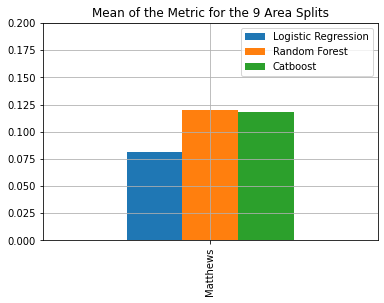

In [49]:
bp.area_split_mean_plot(
    diff_radius_result_9_areas["radius_25"][["Matthews"]],
    "Mean of the Metric for the 9 Area Splits",
)

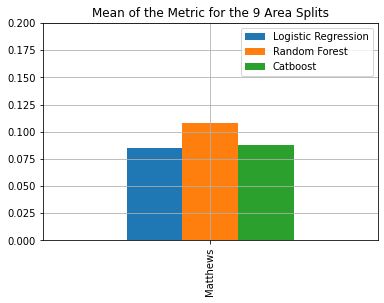

In [50]:
bp.area_split_mean_plot(
    diff_radius_result_9_areas["radius_50"][["Matthews"]],
    "Mean of the Metric for the 9 Area Splits",
)

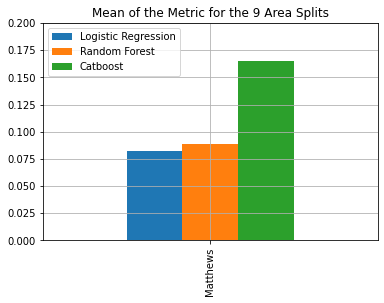

In [51]:
bp.area_split_mean_plot(
    diff_radius_result_9_areas["radius_100"][["Matthews"]],
    "Mean of the Metric for the 9 Area Splits",
)

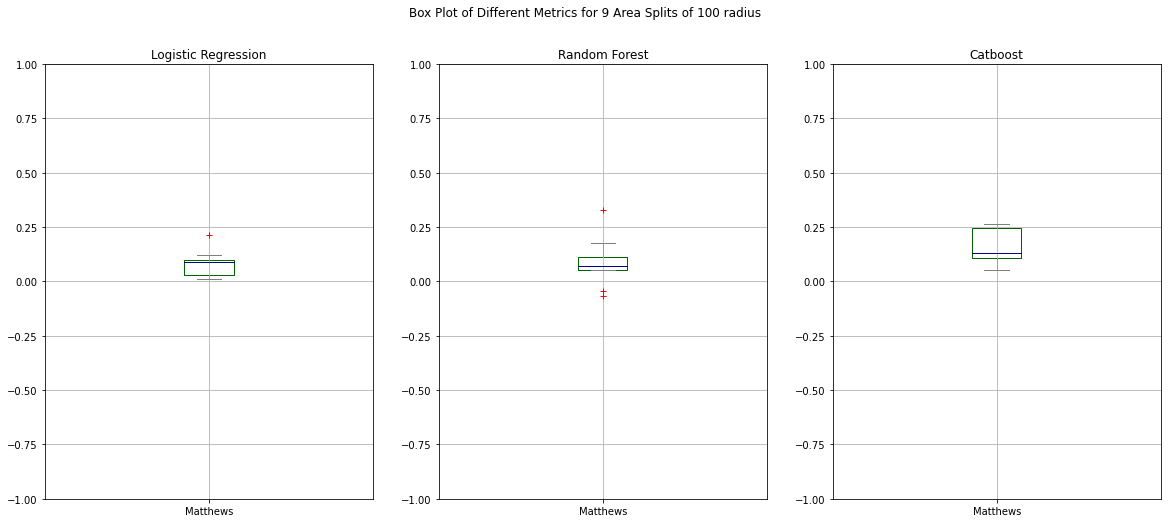

In [52]:
bp.area_split_boxplot(
    diff_radius_result_9_areas["radius_100"][["Matthews"]],
    "Box Plot of Different Metrics for 9 Area Splits of 100 radius",
)

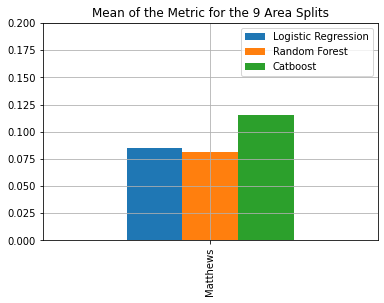

In [53]:
bp.area_split_mean_plot(
    diff_radius_result_9_areas["radius_150"][["Matthews"]],
    "Mean of the Metric for the 9 Area Splits",
)

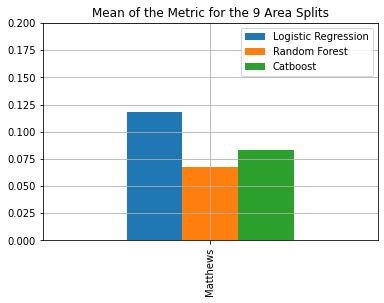

In [54]:
bp.area_split_mean_plot(
    diff_radius_result_9_areas["radius_250"][["Matthews"]],
    "Mean of the Metric for the 9 Area Splits",
)

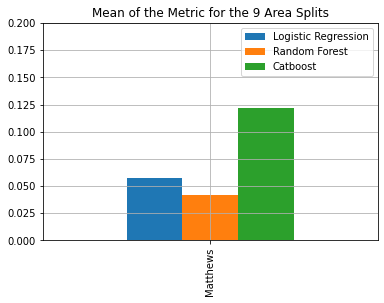

In [55]:
bp.area_split_mean_plot(
    diff_radius_result_9_areas["radius_500"][["Matthews"]],
    "Mean of the Metric for the 9 Area Splits",
)

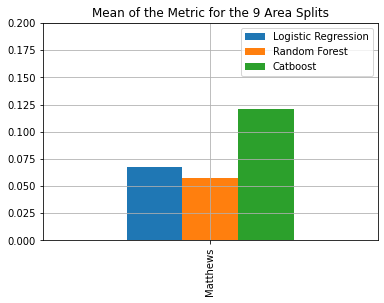

In [56]:
bp.area_split_mean_plot(
    diff_radius_result_9_areas["radius_all"][["Matthews"]],
    "Mean of the Metric for the 9 Area Splits",
)

In [57]:
diff_radius_result_9_areas["radius_all"].Matthews.loc[:, "Catboost"].mean()

0.1209148746908283

In [58]:
diff_radius_result_9_areas["radius_100"].Matthews.loc[:, "Catboost"].mean()

0.16533440910739913

**Conclusion:**

**Catboost trained on 100 radius works the best for 9 areas, therefore, the result given by it is our baseline model performance which is Matthew of 0.16045991565644174. We can also conclude that when we tries to use all radius, it seems that it will confuse the algorithm**

## 4.2 Result with training for 4 Areas

This part we wish to tested out the direct transfer in the 4 areas which are concentrated in the city center

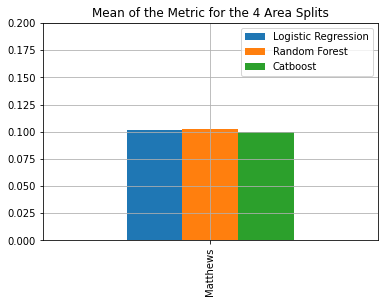

In [59]:
bp.area_split_mean_plot(
    diff_radius_result_4_areas["radius_25"][["Matthews"]],
    "Mean of the Metric for the 4 Area Splits",
)

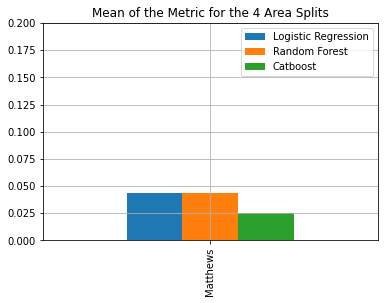

In [60]:
bp.area_split_mean_plot(
    diff_radius_result_4_areas["radius_50"][["Matthews"]],
    "Mean of the Metric for the 4 Area Splits",
)

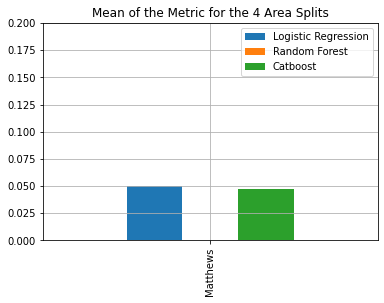

In [61]:
bp.area_split_mean_plot(
    diff_radius_result_4_areas["radius_100"][["Matthews"]],
    "Mean of the Metric for the 4 Area Splits",
)

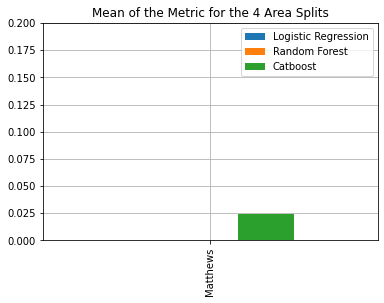

In [62]:
bp.area_split_mean_plot(
    diff_radius_result_4_areas["radius_150"][["Matthews"]],
    "Mean of the Metric for the 4 Area Splits",
)

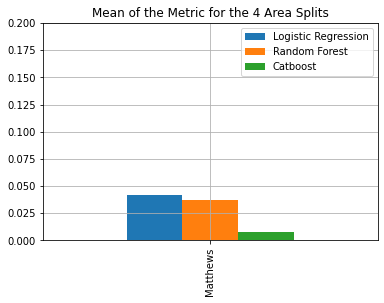

In [63]:
bp.area_split_mean_plot(
    diff_radius_result_4_areas["radius_250"][["Matthews"]],
    "Mean of the Metric for the 4 Area Splits",
)

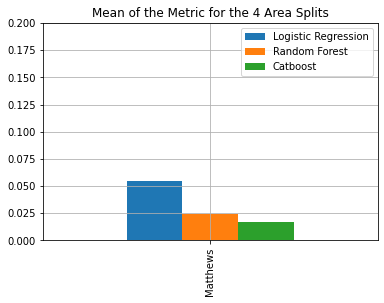

In [64]:
bp.area_split_mean_plot(
    diff_radius_result_4_areas["radius_500"][["Matthews"]],
    "Mean of the Metric for the 4 Area Splits",
)

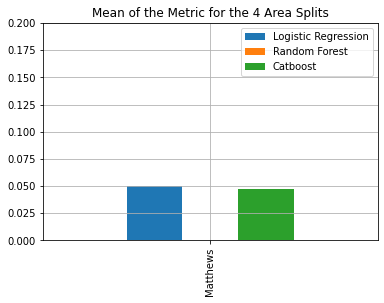

In [65]:
bp.area_split_mean_plot(
    diff_radius_result_4_areas["radius_100"][["Matthews"]],
    "Mean of the Metric for the 4 Area Splits",
)

**Conclusion:**

**4 Areas in the city center does not work so well compared to model trained on 9 areas, therefore, we have determined our baseline as:**

       the catboost model trained on 100 radius data and on the 9 areas split, with a Matthews of 17%

# 5. Select and Save the Data

Here we select the data, and push it to s3

In [66]:
if sagemaker_mode:
    train_data_with_trans_100_with_transaction = different_radius_data_with_holiday.drop(
        radius_25_cols + radius_50_cols + radius_150_cols + radius_250_cols + radius_500_cols, axis=1)

    train_data_with_trans_100_with_transaction.head(1)

    train_data_with_trans_100_with_transaction.to_csv('train_data_with_trans_100_with_transaction.csv')


    print(f'uploading file to object to s3')
    client.upload_file('train_data_with_trans_100_with_transaction.csv',
                       'bucket-vwfs-pred-park-global-model-serving-dev',
                       'input/open_data/seattle/train_data_with_trans_100_with_transaction.csv')
    print('file upload finished')

# 6. Feature Importance of the Best Performing Model

In [67]:
df_9_areas_catboost

,,length,current_capacity,tempC,windspeedKmph,precipMM,ongoing_trans,highway,hour,weekday,commercial_25,residential_25,transportation_25,schools_25,eventsites_25,restaurant_here_25,shopping_here_25,office_here_25,supermarket_here_25,transportation_here_25,schools_here_25,num_off_street_parking_25,off_street_capa_25,commercial_50,residential_50,transportation_50,schools_50,eventsites_50,restaurant_here_50,shopping_here_50,office_here_50,supermarket_here_50,transportation_here_50,schools_here_50,num_off_street_parking_50,off_street_capa_50,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,num_off_street_parking_100,off_street_capa_100,commercial_150,residential_150,transportation_150,schools_150,eventsites_150,restaurant_here_150,shopping_here_150,office_here_150,supermarket_here_150,transportation_here_150,schools_here_150,num_off_street_parking_150,off_street_capa_150,commercial_250,residential_250,transportation_250,schools_250,eventsites_250,restaurant_here_250,shopping_here_250,office_here_250,supermarket_here_250,transportation_here_250,schools_here_250,num_off_street_parking_250,off_street_capa_250,commercial_500,residential_500,transportation_500,schools_500,eventsites_500,restaurant_here_500,shopping_here_500,office_here_500,supermarket_here_500,transportation_here_500,schools_here_500,num_off_street_parking_500,off_street_capa_500,study_area
street_id,observation_interval_start,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8671,2019-04-04 08:04:00,68.835,0,14,3,0.0,1.0,secondary,8,3,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,32.0,0.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0,128.0,0.0,0.0,0.0,0.0,3,0,0,0,1,0,1,20,256.0,64.0,0.0,0.0,0.0,5,1,1,0,2,1,1,20,384.0,224.0,0.0,0.0,0.0,19,5,2,2,7,3,2,206,608,1152.0,0.0,64.0,0.0,24,11,2,3,23,6,6,711,Greenlake
7390,2019-04-04 08:13:00,58.163,0,14,3,0.0,0.0,secondary,8,3,0.0,0.0,0.0,0.0,0.0,2,0,1,0,0,0,0,0,64.0,0.0,0.0,0.0,0.0,2,0,1,0,0,0,0,0,160.0,64.0,0.0,0.0,0.0,2,0,1,0,2,0,1,20,160.0,96.0,0.0,0.0,0.0,4,0,1,0,3,0,1,20,224.0,160.0,0.0,32.0,0.0,12,2,1,0,4,2,1,20,608,1024.0,0.0,64.0,0.0,24,11,2,3,19,6,5,300,Greenlake
23879,2019-04-04 08:25:00,181.089,0,14,3,0.0,3.0,secondary,8,3,11.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,11.0,0.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0,33.0,11.0,0.0,0.0,0.0,2,0,0,0,0,0,1,139,66.0,33.0,0.0,0.0,0.0,8,0,0,0,1,0,4,813,110.0,154.0,0.0,0.0,0.0,21,4,3,0,3,0,5,1063,275,352.0,0.0,0.0,0.0,50,7,11,0,15,2,20,2272,South Lake Union
21688,2019-04-04 08:26:00,78.891,0,14,3,0.0,2.0,tertiary,8,3,0.0,0.0,0.0,0.0,0.0,3,0,0,0,0,1,0,0,64.0,64.0,0.0,0.0,0.0,3,1,0,0,1,1,1,186,160.0,64.0,0.0,0.0,0.0,14,4,0,2,1,3,1,186,192.0,160.0,0.0,0.0,0.0,14,6,0,2,4,3,2,206,256.0,576.0,0.0,0.0,0.0,19,7,2,2,7,3,2,206,672,1312.0,0.0,64.0,0.0,31,13,2,4,21,7,6,711,Greenlake
16023,2019-04-04 08:27:00,81.134,0,14,3,0.0,1.0,tertiary,8,3,7.0,0.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0,14.0,7.0,0.0,0.0,0.0,5,1,0,0,0,2,0,0,35.0,28.0,0.0,0.0,0.0,12,3,0,0,1,3,2,206,42.0,56.0,0.0,0.0,0.0,12,5,0,2,3,3,2,206,49.0,133.0,0.0,0.0,0.0,14,7,0,2,8,3,2,206,112,301.0,0.0,7.0,0.0,19,7,2,2,17,6,5,300,Greenlake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,2019-06-01 22:19:00,97.326,0,14,5,0.0,0.0,tertiary,22,5,0.0,0.0,0.0,0.0,0.0,1,0,2,0,0,0,0,0,30.0,0.0,0.0,0.0,0.0,2,1,2,1,1,0,2,526,60.0,30.0,0.0,0.0,0.0,12,15,5,3,3,0,5,771,60.0,30.0,0.0,0.0,0.0,30,21,9,3,6,1,9,1301,300.0,150.0,0.0,0.0,0.0,82,64,16,8,14,1,20,4041,1050,360.0,0.0,0.0,0.0,100,100,29,31,51,6,20,4041,Commercial Core
19356,2019-06-01 22:21:00,98.617,0,14,5,0.0,0.0,tertiary,22,5,0.0,0.0,0.0,0.0,0.0,1,0,0,0,

In [68]:
y_9_areas

,,availability
street_id,observation_interval_start,
8671,2019-04-04 08:04:00,1.0
7390,2019-04-04 08:13:00,1.0
23879,2019-04-04 08:25:00,0.0
21688,2019-04-04 08:26:00,0.0
16023,2019-04-04 08:27:00,1.0
...,...,...
980,2019-06-01 22:19:00,1.0
19356,2019-06-01 22:21:00,1.0
17924,2019-06-01 22:27:00,0.0


In [69]:
# train the model catboost again with 9 area splits
df_9_areas_catboost_100 = df_9_areas_catboost.drop(
    radius_25_cols
    + radius_50_cols
    + radius_150_cols
    + radius_250_cols
    + radius_500_cols,
    axis=1,
)

**Note: 22 features are left and used for training**

In [70]:
df_9_areas_catboost_100

,,length,current_capacity,tempC,windspeedKmph,precipMM,ongoing_trans,highway,hour,weekday,commercial_100,residential_100,transportation_100,schools_100,eventsites_100,restaurant_here_100,shopping_here_100,office_here_100,supermarket_here_100,transportation_here_100,schools_here_100,num_off_street_parking_100,off_street_capa_100,study_area
street_id,observation_interval_start,,,,,,,,,,,,,,,,,,,,,,,
8671,2019-04-04 08:04:00,68.835,0,14,3,0.0,1.0,secondary,8,3,128.0,0.0,0.0,0.0,0.0,3,0,0,0,1,0,1,20,Greenlake
7390,2019-04-04 08:13:00,58.163,0,14,3,0.0,0.0,secondary,8,3,160.0,64.0,0.0,0.0,0.0,2,0,1,0,2,0,1,20,Greenlake
23879,2019-04-04 08:25:00,181.089,0,14,3,0.0,3.0,secondary,8,3,33.0,11.0,0.0,0.0,0.0,2,0,0,0,0,0,1,139,South Lake Union
21688,2019-04-04 08:26:00,78.891,0,14,3,0.0,2.0,tertiary,8,3,160.0,64.0,0.0,0.0,0.0,14,4,0,2,1,3,1,186,Greenlake
16023,2019-04-04 08:27:00,81.134,0,14,3,0.0,1.0,tertiary,8,3,35.0,28.0,0.0,0.0,0.0,12,3,0,0,1,3,2,206,Greenlake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,2019-06-01 22:19:00,97.326,0,14,5,0.0,0.0,tertiary,22,5,60.0,30.0,0.0,0.0,0.0,12,15,5,3,3,0,5,771,Commercial Core
19356,2019-06-01 22:21:00,98.617,0,14,5,0.0,0.0,tertiary,22,5,30.0,60.0,0.0,0.0,0.0,9,8,2,3,5,0,4,1062,Commercial Core
17924,2019-06-01 22:27:00,58.121,0,14,5,0.0,0.0,primary,22,5,180.0,240.0,0.0,0.0,0.0,11,4,1,1,3,0,2,1409,Commercial Core


In [71]:
# train the best model and get the feature importance for every feature for every area combo
df_result_9_areas_100, feature_importance = bh.train_best_model(
    X_different_areas_catboost_100=df_9_areas_catboost_100,
    cat_feat=cat_features,
    y_different_areas_100=y_9_areas,
)

Learning rate set to 0.020581
0:	learn: 0.6906944	total: 5.53ms	remaining: 5.53s
200:	learn: 0.5353298	total: 1.22s	remaining: 4.83s
400:	learn: 0.4670873	total: 2.54s	remaining: 3.8s
600:	learn: 0.4106868	total: 3.93s	remaining: 2.61s
800:	learn: 0.3736376	total: 5.36s	remaining: 1.33s
999:	learn: 0.3456008	total: 6.55s	remaining: 0us
Learning rate set to 0.019496
0:	learn: 0.6910553	total: 11.1ms	remaining: 11.1s
200:	learn: 0.5311783	total: 1.11s	remaining: 4.42s
400:	learn: 0.4707959	total: 2.28s	remaining: 3.41s
600:	learn: 0.4151524	total: 3.7s	remaining: 2.45s
800:	learn: 0.3765006	total: 4.76s	remaining: 1.18s
999:	learn: 0.3481310	total: 5.92s	remaining: 0us
Learning rate set to 0.018889
0:	learn: 0.6909657	total: 4.95ms	remaining: 4.95s
200:	learn: 0.5261370	total: 910ms	remaining: 3.62s
400:	learn: 0.4622445	total: 1.96s	remaining: 2.93s
600:	learn: 0.4084568	total: 3.04s	remaining: 2.02s
800:	learn: 0.3631729	total: 4.08s	remaining: 1.01s
999:	learn: 0.3321790	total: 5.01s	

In [72]:
# get the feature importance and concat to a dataframe for plotting
feature_importance = {
    k: v.set_index("Feature Id") for k, v in feature_importance.items()
}
df_feature_importance = pd.concat(feature_importance, axis=1).T
# drop one index level
df_feature_importance.index = df_feature_importance.index.droplevel(-1)

In [73]:
len(df_feature_importance)

9

Text(0.5, 1.0, 'Boxplot for All Features and All Area Combinations')

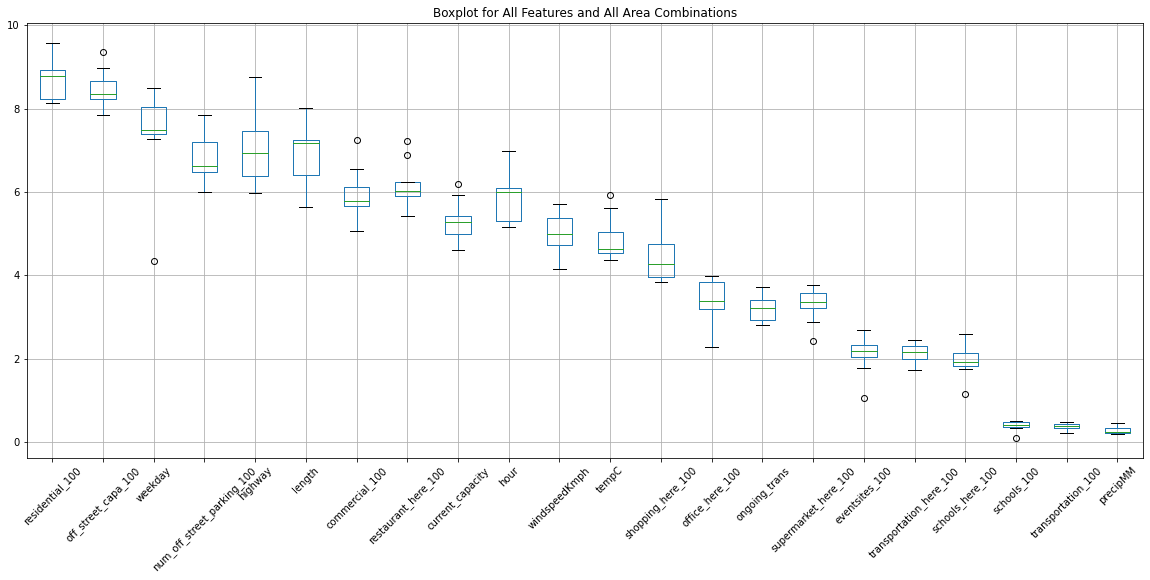

In [74]:
df_feature_importance
df_feature_importance.boxplot(
    column=list(df_feature_importance.columns), rot=45, figsize=(20, 8)
)
plt.title("Boxplot for All Features and All Area Combinations")

**Conclusion:**

**As we can see the off-street-capacity of the parking facility, the number of residential building in a 100 radius as well as the weekday seems to have the highest feature importance, the precipcion of that day has the smallest feature importance**